# Data Transformation Task for Data Mining Project

This notebook is dedicated to the data transformation task of the data mining project. Specifically, it will address the following tasks:

1. Replace the `nan` values in the `climb_total` feature based on the information provided by the of correlated features of the races dataset.
2. Once the `climb_total` has been filled, replace the `nan` values in the `profile` feature based on the correlated features and the modified `climb_total` feature.
3. Apply the best technique to predict the `uci_points` feature.

This notebook will guide you through each step, ensuring a comprehensive understanding of the data transformation process.



### Install or Import Packages

In the next Python cell, we will ensure that all necessary packages are installed or imported. This step is crucial to make sure that we have all the dependencies required for the data transformation tasks in this notebook.

In [ ]:
import subprocess
import sys
import importlib.util
import psutil
import multiprocessing as mp
import warnings

def check_and_install(package):
    """
        This function checks if a package is installed and installs it if not.
    """

    if importlib.util.find_spec(package) is None:
        print(f"{package} not found, installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")
    
# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "xgboost",
    "lightgbm",
    "tqdm",
    "ipywidgets",
    "pandarallel",

]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)

real_cpu_count = psutil.cpu_count(logical=False)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as mse
from sklearn.metrics import r2_score, silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

from scipy.stats import kstest
from scipy import stats

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from tqdm import tqdm

from ipywidgets import interact

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

scikit-learn not found, installing...
scikit-learn has been installed
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Import Dataset

In the next cell, we will import the dataset called `races`. This dataset will be used for the data transformation tasks outlined in this notebook.

In [5]:
# Assuming the dataset is in a CSV file named 'races.csv'
races_ = pd.read_csv('dataset/races_updated.csv')
# The dataset contains information about races, including race name, date, distance, and location.
# Print the information about the races dataframe
print("The races dataframe contains information about races, including race name, date, distance, and location.")


# Print the summary information of the races dataframe
races_.info(verbose=True, show_counts=True)


The races dataframe contains information about races, including race name, date, distance, and location.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586939 entries, 0 to 586938
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 586939 non-null  object 
 1   name                 586939 non-null  object 
 2   points               586939 non-null  float64
 3   uci_points           250055 non-null  float64
 4   length               586939 non-null  float64
 5   climb_total          440512 non-null  float64
 6   profile              439344 non-null  float64
 7   startlist_quality    586939 non-null  int64  
 8   average_temperature  29861 non-null   float64
 9   date                 586939 non-null  object 
 10  position             586939 non-null  int64  
 11  cyclist              586939 non-null  object 
 12  cyclist_age          586827 non-null  float64
 13  is_tarmac     

### Identifying Common Races with Missing and Complete Climb Total Data

In this section, we aim to identify races that have both missing and complete `climb_total` data. This is achieved by grouping the dataset by the `_url` and `name` columns, and then calculating the number of missing values in the `climb_total` feature for each group. 

We then separate the groups into two categories:
1. `res_na`: Groups where the `climb_total` feature has missing values.
2. `res_no_na`: Groups where the `climb_total` feature has no missing values.

Finally, we identify the common indices between these two categories, which represent the races that have both missing and complete `climb_total` data. This information is crucial for understanding the distribution of missing data and for designing appropriate imputation strategies.


In [6]:
grouped = races_.groupby(["_url", "name"])
res_temp = grouped[['_url', 'name', 'climb_total']].apply(lambda x: x.isna().sum())
res_na = res_temp[res_temp['climb_total'] > 0]
res_no_na = res_temp[res_temp['climb_total'] == 0]


common_index = res_na.index.intersection(res_no_na.index)
common_index

MultiIndex([], names=['_url', 'name'])

### Identifying Common Races with Missing and Complete Profile Data

In this section, we aim to identify races that have both missing and complete `profile` data. This is achieved by grouping the dataset by the `_url` and `name` columns, and then calculating the number of missing values in the `profile` feature for each group. 

We then separate the groups into two categories:
1. `res_na`: Groups where the `profile` feature has missing values.
2. `res_no_na`: Groups where the `profile` feature has no missing values.

Finally, we identify the common indices between these two categories, which represent the races that have both missing and complete `profile` data. This information is crucial for understanding the distribution of missing data and for designing appropriate imputation strategies.


In [7]:
res_temp = grouped[['_url', 'name', 'profile']].apply(lambda x: x.isna().sum())

res_na = res_temp[res_temp['profile'] > 0]
res_no_na = res_temp[res_temp['profile'] == 0]

common_index = res_na.index.intersection(res_no_na.index)
common_index

MultiIndex([], names=['_url', 'name'])


### Data Preprocessing and Feature Engineering

In this section, we will preprocess the data and engineer new features to enhance the predictive power of our models. The steps include:

1. **Handling Missing Values**: We will use various imputation strategies to handle missing values in the dataset. This includes mean, median, and most frequent imputation, as well as iterative imputation using a RandomForestRegressor.
2. **Feature Scaling and Transformation**: We will apply robust scaling and power transformation to numeric features to ensure they are on a similar scale and to reduce skewness.
3. **Feature Engineering**: We will create new features such as `season`, `team_present`, `startlist_score_per_km`, and `adjusted_delta` to capture additional information from the existing data.
4. **Validation of Features**: We will ensure that all required features are present in the dataset and raise an error if any are missing.
5. **Imputation and Transformation**: We will apply the appropriate imputation and transformation techniques to each feature based on its type (numeric, boolean, or categorical).
6. **Aggregation**: Finally, we will aggregate the data at the race level to prepare it for further analysis and modeling.

This comprehensive preprocessing and feature engineering pipeline will help us build robust predictive models for the `climb_total` feature.

In [8]:
def engineering_features_t1(df) -> tuple[pd.DataFrame, dict]:
    
    engineered_features = {
        'points_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season_score': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season': {
            'type': 'categorical',
            'agg': pd.Series.mode
        },
        'team_presents': {
            'type': 'numeric',
            'agg': pd.Series.sum
        },
        'adjusted_delta': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'startlist_score_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        }
    }
            
    # Process date features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear

    # Calculate derived features
    df['points_per_km'] = (df['points'] / df['length']* 0.001).fillna(0)


    # Create seasonal feature
    df['season_score'] = np.sin(2 * np.pi * df['day_of_year'] / 365)

    temp = df['month'].apply(lambda x: 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' if x in [9, 10, 11] else 'winter')
    label_enc = LabelEncoder().fit_transform(temp.to_numpy())
    df['season'] = pd.Series(label_enc, index=df.index)
    df['team_presents'] = df['cyclist_team'].notnull().astype(int)
    df['startlist_score_per_km'] = df['startlist_quality'] / (df['length'] * 0.001)

    df['adjusted_delta'] = df['delta'] / df['length']

    return df, engineered_features



In [68]:
from sklearn.impute import KNNImputer


mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
knn_imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()


iterative_imputer = IterativeImputer(max_iter=40, estimator=RandomForestRegressor())

def preprocess_helper_imputer(races, pred_features ):
    missing_features = [feature for feature in pred_features if feature not in races.columns]

    if len(missing_features) > 0:
        raise ValueError(f"Missing features in the dataset: {missing_features}")


    for feature, info in pred_features.items():
        if info['type'] == 'boolean':
            feature_data = races[feature].astype(float).to_numpy().reshape(-1, 1)
            imputed_data = iterative_imputer.fit_transform(feature_data)
            races[feature] = pd.Series(imputed_data.flatten(), index=races[feature].index)
        
        elif info['type'] == 'numeric' and not feature == "points":
            feature_data = races[feature].to_numpy().reshape(-1, 1)

            non_nan_data = races[feature].dropna()
            if len(non_nan_data) > 0:
                skewness = non_nan_data.skew()
                if abs(skewness) > 1:
                    imputed_data = median_imputer.fit_transform(feature_data)
                else:
                    imputed_data = mean_imputer.fit_transform(feature_data)
            else:
                imputed_data = median_imputer.fit_transform(feature_data)
            
            races[feature] = pd.Series(imputed_data.flatten(), index=races[feature].index)
        elif info['type'] == 'numeric' and feature == "points":
            # get the median for each cyclist
            res = races.groupby("cyclist").agg({feature: 'mean'})
            races_feat_nan = races[races[feature].isna()]
            races.loc[races_feat_nan.index, feature] = races[['cyclist', feature]].loc[races_feat_nan.index].apply(lambda x: res.loc[x['cyclist'], feature], axis=1)
            
        elif info['type'] == 'categorical':
            feature_data = pd.Categorical(races[feature]).to_numpy().reshape(-1, 1)
            imputed_data = LabelEncoder().fit_transform(feature_data.ravel())
            imputed_data = iterative_imputer.fit_transform(imputed_data.reshape(-1, 1))
            races[feature] = pd.Series(imputed_data.flatten(), index=races[feature].index)


def preprocess_helper_scaler(races, pred_features):
    for feature, info in pred_features.items():
        if info['type'] == 'numeric':
            scaled_data = scaler.fit_transform(races[feature].to_numpy().reshape(-1, 1))
            races[feature] = pd.Series(scaled_data.flatten(), index=races[feature].index)











# Define features with their properties and aggregation methods
normal_features = {
    'length': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'points': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'startlist_quality': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'is_tarmac': {
        'type': 'boolean',
        'agg': 'first'
    },
    'profile': {
        'type': 'categorical',
        'agg': pd.Series.mode
    },
    'position': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'cyclist_age': {
        'type': 'numeric',
        'agg': pd.Series.median
    }
    
}

races_climb = races_[list(normal_features.keys()) + ['climb_total', 'date', 'cyclist', 'cyclist_team', 'delta', '_url']].copy()


preprocess_helper_imputer(races_climb, normal_features)
_, engineered_features = engineering_features_t1(races_climb)


FEATURES = {**normal_features, **engineered_features}
preprocess_helper_scaler(races_climb, FEATURES)


# Generate pred_features dictionary
pred_features = {name: {'type': props['type']} for name, props in FEATURES.items()}

# Generate aggregation dictionary
agg_dict = {name: props['agg'] for name, props in FEATURES.items()}
agg_dict['climb_total'] = pd.Series.mean
agg_dict['date'] = 'first'

# Perform groupby with generated aggregation dictionary
races_agg = races_climb.groupby(["_url"]).agg(agg_dict)

races_agg.sample(frac=0.4).head(10)

length    points  startlist_quality  \
_url                                                                         
il-lombardia/2006/result             1.211917  3.413932          -0.460240   
paris-roubaix/1994/result            1.599240  3.413932          -1.865965   
vuelta-a-espana/2020/stage-2        -0.235124 -0.169602          -1.075080   
la-fleche-wallone/1983/result        1.258395  2.495077          -1.093473   
tour-de-france/1984/stage-22        -1.793713  0.197940           1.394791   
tour-de-france/2011/stage-8          0.359805  0.197940           1.607620   
tour-de-france/1983/stage-12         1.351353  0.197940           0.441000   
itzulia-basque-country/2017/stage-4  0.113467 -0.720915          -0.762405   
volta-a-catalunya/2016/stage-4       0.084031 -0.720915          -0.147565   
tour-de-romandie/1975/stage-2        0.313326 -0.720915          -1.766119   

                                     is_tarmac  profile  position  \
_url                                                                
il-lombardia/2006/result                   0.0      5.0 -0.541680   
paris-roubaix/1994/result                  0.0      5.0 -1.058167   
vuelta-a-espana/2020/stage-2               1.0      3.0  0.222719   
la-fleche-wallone/1983/result              0.0      5.0 -0.779264   
tour-de-france/1984/stage-22               1.0      1.0 -0.262778   
tour-de-france/2011/stage-8                1.0      4.0  0.357006   
tour-de-france/1983/stage-12               1.0      2.0 -0.386735   
itzulia-basque-country/2017/stage-4        1.0      3.0 -0.025194   
volta-a-catalunya/2016/stage-4             1.0      4.0  0.222719   
tour-de-romandie/1975/stage-2              1.0      5.0 -1.419707   

                                     cyclist_age  points_per_km  season_score  \
_url                                                                            
il-lombardia/2006/result               -0.385501       0.002893     -1.706070   
paris-roubaix/1994/result               0.392656      -0.035797      1.167478   
vuelta-a-espana/2020/stage-2           -0.385501      -0.218510     -1.647124   
la-fleche-wallone/1983/result          -0.774580      -0.077215      1.148933   
tour-de-france/1984/stage-22           -0.644887       0.314977     -0.785950   
tour-de-france/2011/stage-8             0.133271      -0.219027     -0.468457   
tour-de-france/1983/stage-12           -0.644887      -0.268395     -0.567900   
itzulia-basque-country/2017/stage-4     0.133271      -0.308045      1.179163   
volta-a-catalunya/2016/stage-4          0.133271      -0.306865      1.172667   
tour-de-romandie/1975/stage-2           0.262963      -0.315420      0.900737   

                                     season  team_presents  climb_total  \
_url                                                                      
il-lombardia/2006/result                  0      13.907552       4036.0   
paris-roubaix/1994/result                 1     -18.740134          NaN   
vuelta-a-espana/2020/stage-2              0      88.179712       2435.0   
la-fleche-wallone/1983/result             1     -65.408583          NaN   
tour-de-france/1984/stage-22              2     -93.589607        744.0   
tour-de-france/2011/stage-8               2     109.599844       3019.0   
tour-de-france/1983/stage-12              2     -94.125607       2500.0   
itzulia-basque-country/2017/stage-4       1      73.590221       2668.0   
volta-a-catalunya/2016/stage-4            1      49.880153       4644.0   
tour-de-romandie/1975/stage-2             1       2.788915          NaN   

                                                   date  
_url                                                     
il-lombardia/2006/result            2006-10-14 06:08:06  
paris-roubaix/1994/result           1994-04-10 07:28:02  
vuelta-a-espana/2020/stage-2        2020-10-21 03:47:04  
la-fleche-wallone/1983/result       1983-04-14 06:56:00  
tour-de-france/1984/stage-22        1984-07-21 01:0

This code defines a function `compare_algorithms` to evaluate various machine learning models for predicting the `climb_total` values in a dataset. The function performs the following tasks:

1. **Data Preparation**:
    - Splits the dataset into training and prediction sets based on the presence of `climb_total` values.
    - Extracts feature columns and target variable (`climb_total`).

2. **Model Definition**:
    - Defines a dictionary of models and their hyperparameters to be compared, including Random Forest, Gradient Boosting, XGBoost, Huber, Linear Regression, Ridge, Lasso, KNeighborsRegressor, HistGradientBoostingRegressor, and VotingRegressor.

3. **Model Training and Evaluation**:
    - Trains each model using `RandomizedSearchCV` for hyperparameter tuning.
    - Evaluates models based on RMSE, R², and cross-validation RMSE.
    - Stores the best model and its performance metrics.

4. **Visualization**:
    - Plots RMSE and R² scores for model comparison.
    - Plots residuals for the best model.

5. **Summary**:
    - Creates a summary DataFrame of model performance metrics.
    - Returns the trained models, summary, and predictions for missing `climb_total` values.

The function is then called with the dataset `races_agg` and feature definitions `pred_features`, and the best model is used to make predictions.


In [75]:


def compare_algorithms(races_agg, feature_to_pred, features):
    warnings.filterwarnings('ignore')
    """
    Compare different algorithms for predicting ```feature_to_pred``` values.
    
    Parameters:
    races_agg (pd.DataFrame): Input DataFrame
    features (list): List of feature columns to use
    
    Returns:
    dict: Dictionary containing trained models and their performance metrics
    """
    # Prepare data
    known_mask = ~races_agg[feature_to_pred].isna()
    train_data = races_agg[known_mask]
    predict_data = races_agg[~known_mask]
    
    X = train_data[features.keys()].copy()
    X_to_pred = predict_data[features.keys()].copy()
    y = train_data[feature_to_pred]

    for feature, info in features.items():
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame")
        
        if info['type'] not in ['numeric', 'categorical', 'boolean']:
            raise ValueError(f"Unknown feature type: {info['type']}")

        
    
   
    
    # Handle missing values
    
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )
    
    
    

    models = {
        'Random Forest': RandomForestRegressor(n_jobs=real_cpu_count, n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=15),
        'Gradient Boosting': GradientBoostingRegressor(subsample=0.8, n_estimators=100, min_samples_split=15, max_depth=5, learning_rate=0.05),
        'XGBoost': XGBRegressor(subsample=0.9, n_estimators=200, min_child_weight=8, max_depth=5, learning_rate=0.04, colsample_bytree=1.0),
        'Huber': HuberRegressor(max_iter = 700, epsilon = 1.5, alpha = 0.01),
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha = 2.0),
        'Lasso': Lasso(alpha= 2.0),
        'KNeighborsRegressor': KNeighborsRegressor(weights = 'distance', n_neighbors = 5, algorithm = 'ball_tree'),
        'HistGradientBoostingRegressor': HistGradientBoostingRegressor(max_iter=80, max_depth=7, learning_rate=0.07, l2_regularization=0.05),
        'VotingRegressor': VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(n_jobs=real_cpu_count, n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=15)),
            ('gb', GradientBoostingRegressor(subsample=0.8, n_estimators=100, min_samples_split=15, max_depth=5, learning_rate=0.05)),
            ('xgb', XGBRegressor(subsample=0.9, n_estimators=200, min_child_weight=8, max_depth=5, learning_rate=0.04, colsample_bytree=1.0)),
            ('hgbr', HistGradientBoostingRegressor(max_iter=80, max_depth=7, learning_rate=0.07, l2_regularization=0.05))
        ], weights=[1, 1, 1, 1])
    }
    
    # Dictionary to store results
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mse(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Perform cross-validation
        cv_scores = cross_val_score(
            model, X, y, 
            cv=5, scoring='neg_root_mean_squared_error'
        )
        
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'cv_rmse': -cv_scores.mean(),
            'cv_rmse_std': cv_scores.std(),
            'predictions': y_pred
        }
        
        print(f"{name} Results:")
        print(f"RMSE: {rmse:.2f} meters")
        print(f"R²: {r2:.3f}")
        print(f"CV RMSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f} meters")
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE comparison
    plt.subplot(2, 1, 1)
    rmse_scores = [(name, results[name]['rmse']) for name in results.keys()]
    rmse_scores.sort(key=lambda x: x[1])
    
    names, scores = zip(*rmse_scores)
    plt.barh(names, scores)
    plt.xlabel('RMSE (meters)')
    plt.title('Model Comparison - RMSE (lower is better)')
    
    # Plot R² comparison
    plt.subplot(2, 1, 2)
    r2_scores = [(name, results[name]['r2']) for name in results.keys()]
    r2_scores.sort(key=lambda x: x[1], reverse=True)
    
    names, scores = zip(*r2_scores)
    plt.barh(names, scores)
    plt.xlabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² Score')
    
    plt.tight_layout()
    plt.show()
    
    # Plot residuals for best model
    best_model_name = min(results.keys(), key=lambda k: results[k]['rmse'])
    best_predictions = results[best_model_name]['predictions']
    
    plt.figure(figsize=(10, 6))
    residuals = y_test - best_predictions
    plt.scatter(best_predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {best_model_name}')
    plt.show()
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'RMSE': [results[name]['rmse'] for name in results.keys()],
        'R²': [results[name]['r2'] for name in results.keys()],
        'CV RMSE': [results[name]['cv_rmse'] for name in results.keys()],
        'CV RMSE Std': [results[name]['cv_rmse_std'] for name in results.keys()]
    }, index=results.keys())
    
    print("\nSummary of all models:")
    print(summary.sort_values('RMSE'))

    feature_predictions = pd.Series(results[best_model_name]['model'].predict(X_to_pred), index=predict_data.index)

    print("Visualizations for the best model:")
    errors_visualization(y_test, best_predictions, feature_to_pred)

    warnings.filterwarnings('default')
    return  results, summary, feature_predictions






Training Random Forest...
Random Forest Results:
RMSE: 26.47 meters
R²: 0.735
CV RMSE: 820.23 ± 89.65 meters

Training Gradient Boosting...
Gradient Boosting Results:
RMSE: 26.37 meters
R²: 0.739
CV RMSE: 835.00 ± 105.55 meters

Training XGBoost...
XGBoost Results:
RMSE: 26.42 meters
R²: 0.737
CV RMSE: 830.42 ± 106.97 meters

Training Huber...
Huber Results:
RMSE: 30.94 meters
R²: 0.505
CV RMSE: 1151.01 ± 218.76 meters

Training Linear Regression...
Linear Regression Results:
RMSE: 30.93 meters
R²: 0.506
CV RMSE: 1152.85 ± 198.86 meters

Training Ridge...
Ridge Results:
RMSE: 30.91 meters
R²: 0.507
CV RMSE: 1150.31 ± 197.84 meters

Training Lasso...
Lasso Results:
RMSE: 30.89 meters
R²: 0.508
CV RMSE: 1148.97 ± 193.50 meters

Training KNeighborsRegressor...
KNeighborsRegressor Results:
RMSE: 29.82 meters
R²: 0.573
CV RMSE: 1069.15 ± 106.88 meters

Training HistGradientBoostingRegressor...
HistGradientBoostingRegressor Results:
RMSE: 26.23 meters
R²: 0.745
CV RMSE: 838.21 ± 102.83 mete

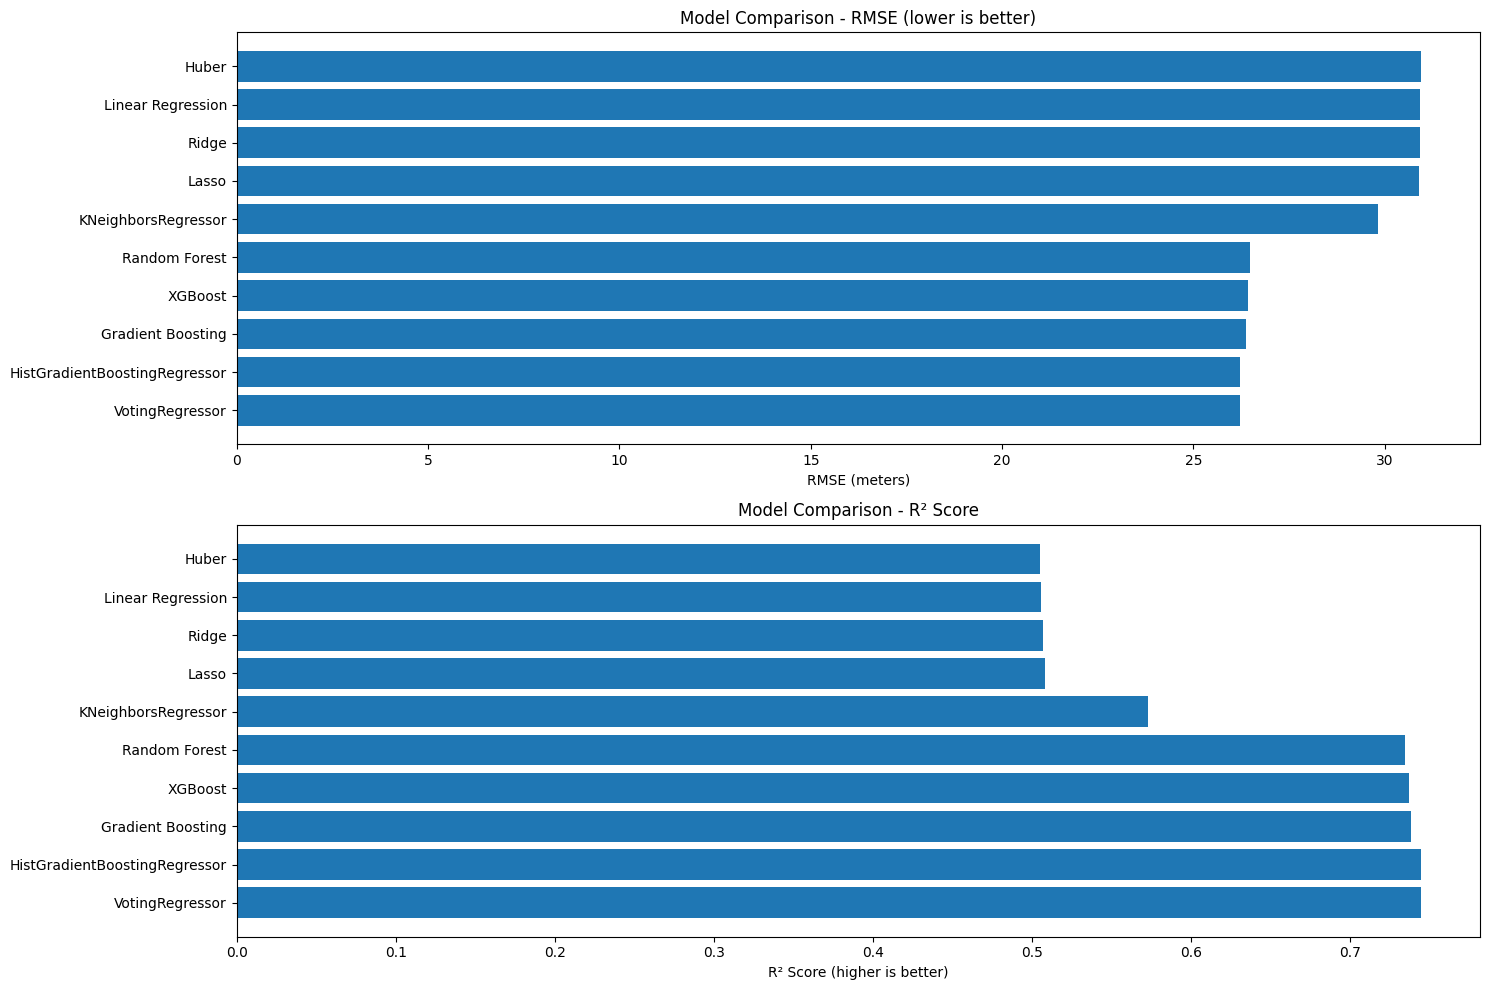

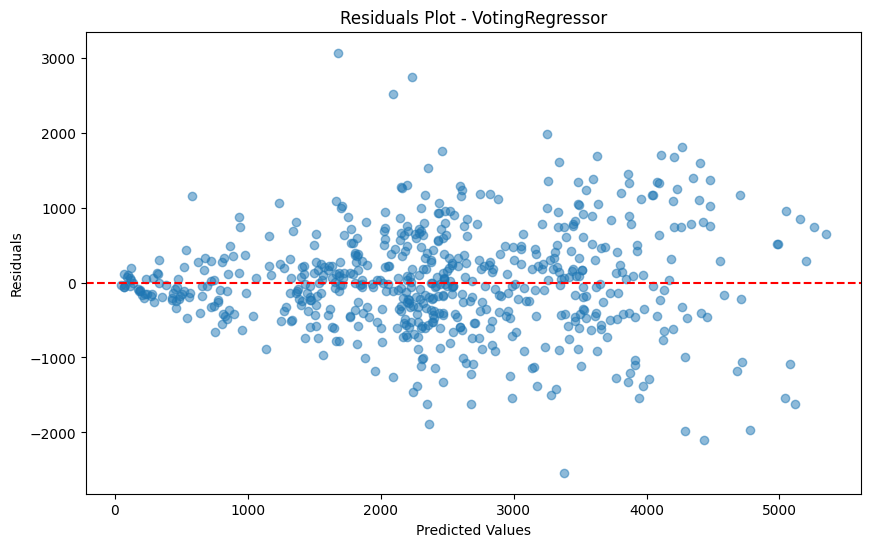


Summary of all models:
                                    RMSE        R²      CV RMSE  CV RMSE Std
VotingRegressor                26.222839  0.744770   821.727213   100.610667
HistGradientBoostingRegressor  26.227433  0.744591   838.214373   102.825702
Gradient Boosting              26.373683  0.738846   834.997554   105.546802
XGBoost                        26.416769  0.737136   830.418720   106.966848
Random Forest                  26.467567  0.735108   820.234872    89.651779
KNeighborsRegressor            29.821679  0.573085  1069.146363   106.884179
Lasso                          30.891593  0.508443  1148.971492   193.504223
Ridge                          30.912276  0.507125  1150.312184   197.844121
Linear Regression              30.928053  0.506118  1152.853017   198.863992
Huber                          30.941955  0.505229  1151.012460   218.763436
Visualizations for the best model:


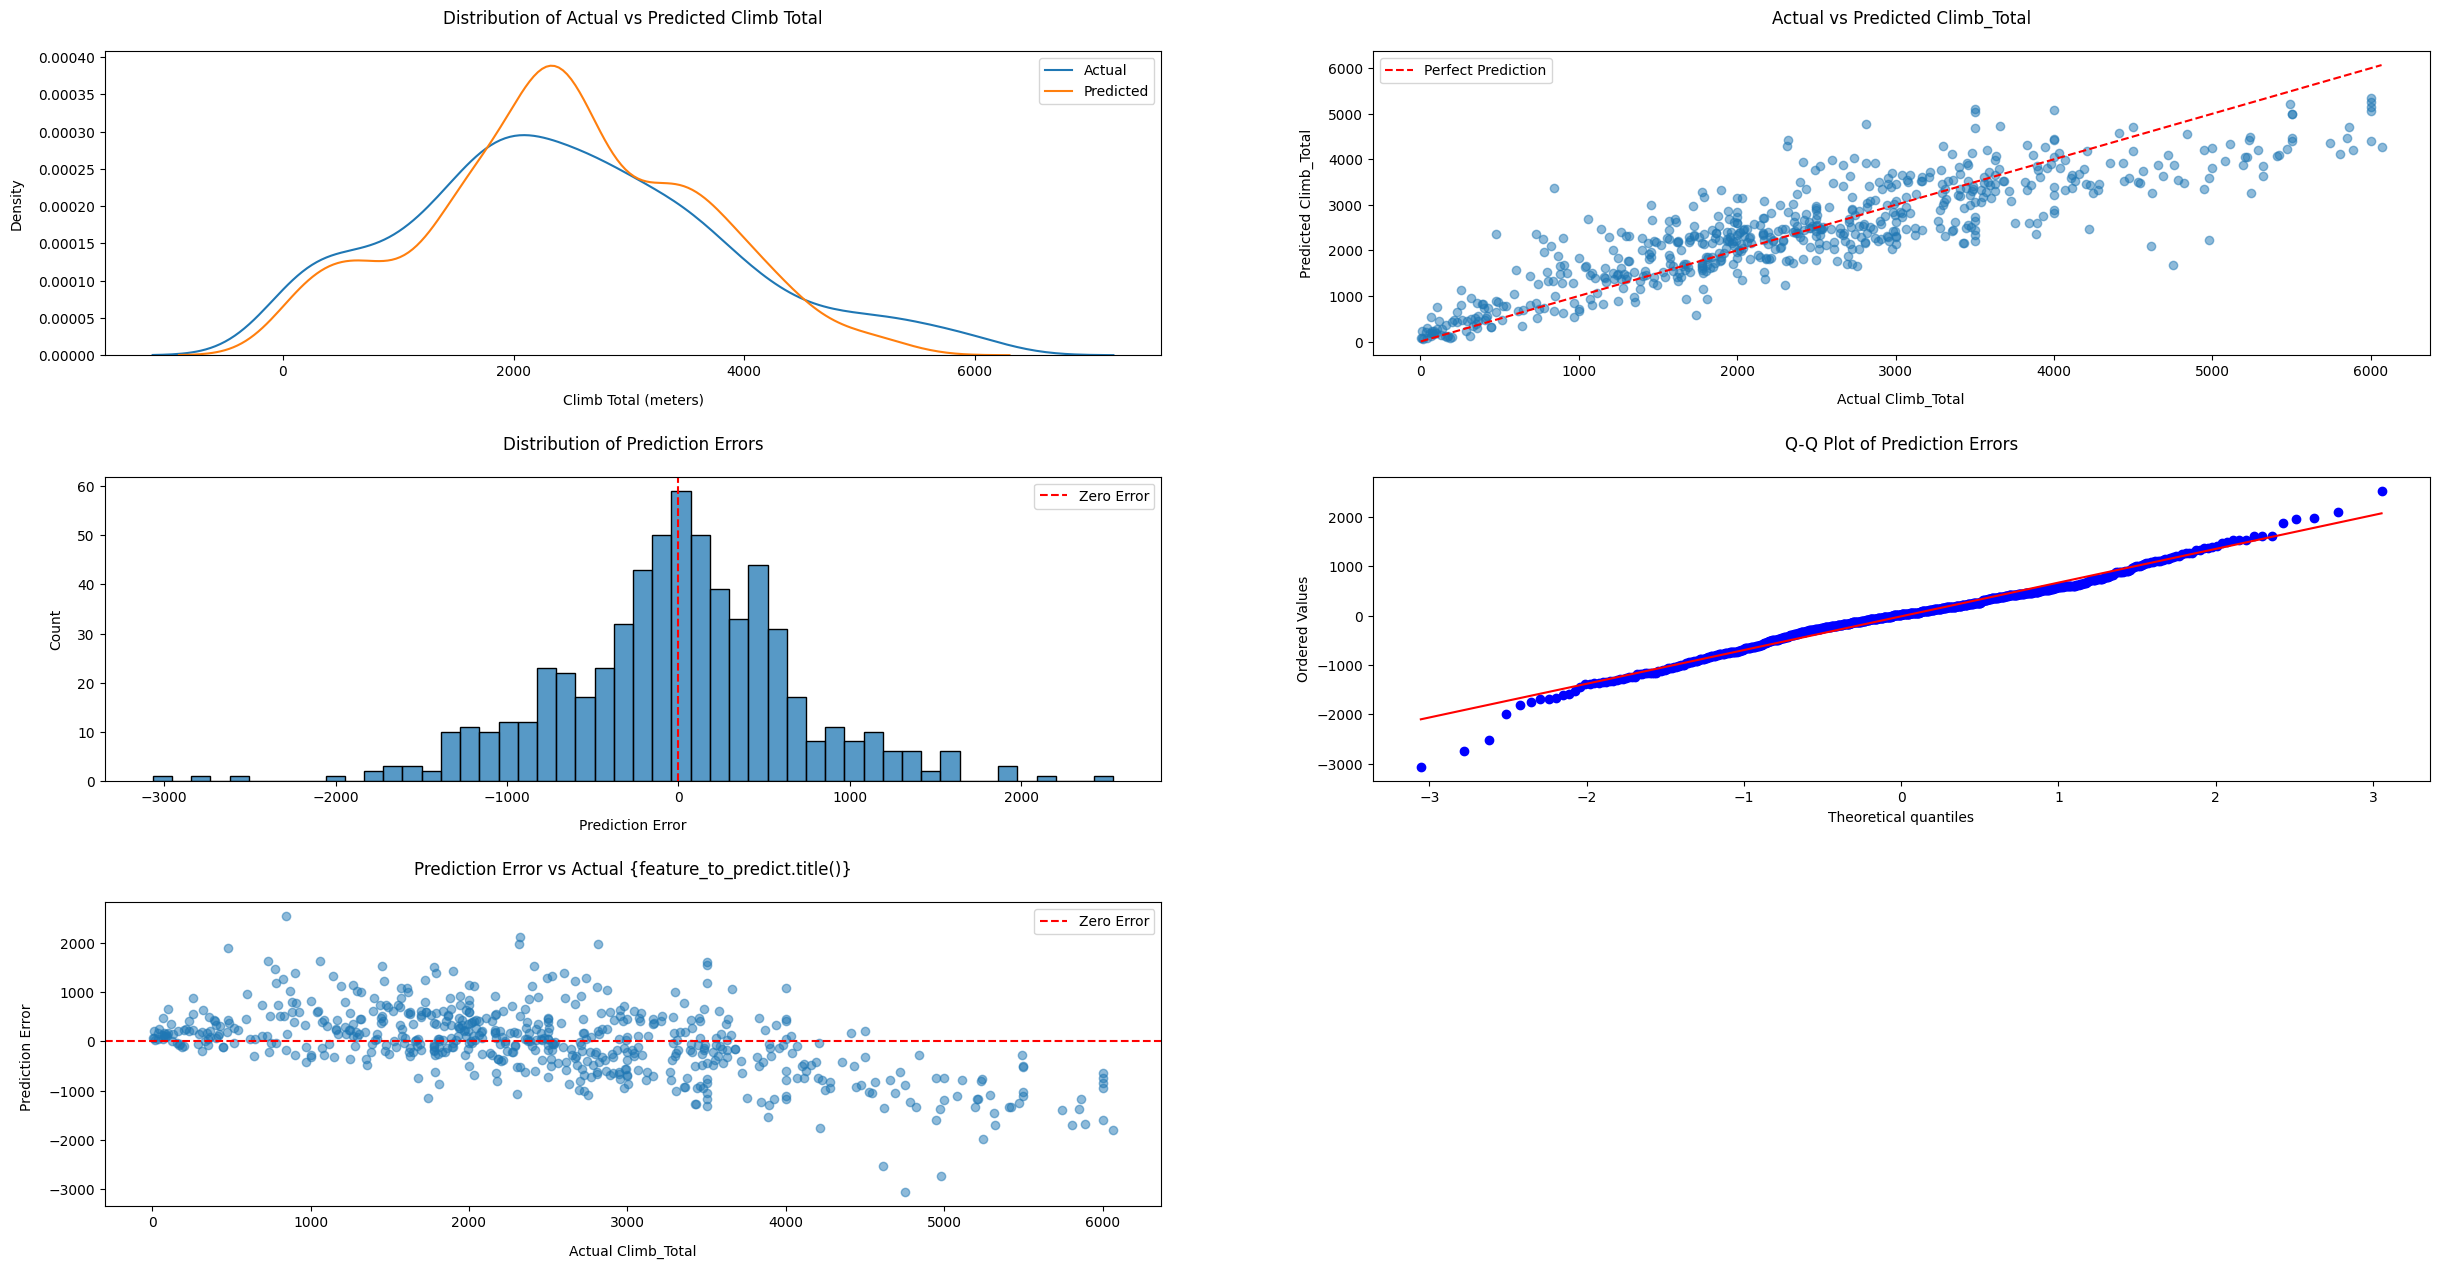

In [78]:
results, summary, climb_total_pred = compare_algorithms(races_agg, "climb_total", features=pred_features)

# Use the best model to make predictions
best_model_name = summary.index[0]
best_model = results[best_model_name]['model']

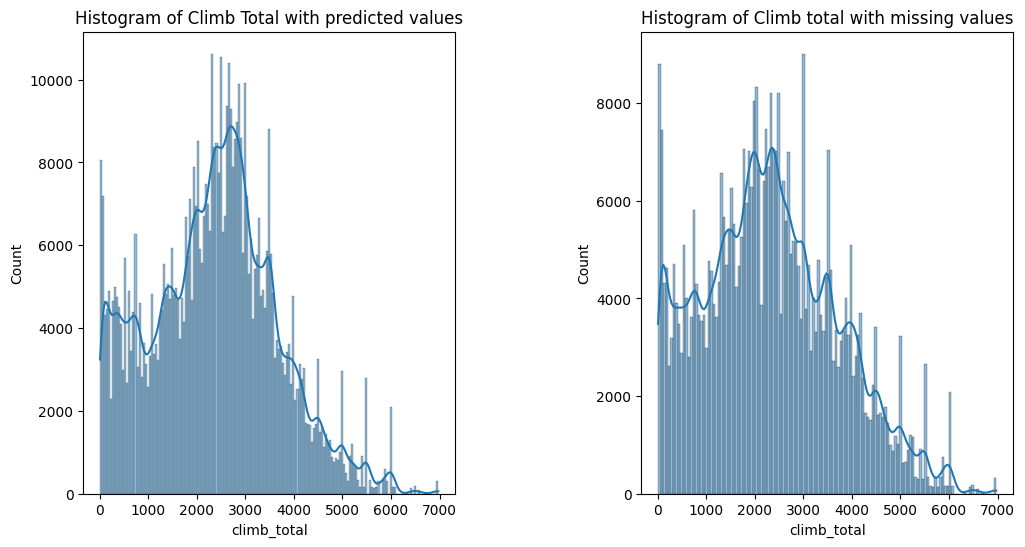

In [83]:
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.5, hspace=0.5)

climb_total_pred_v1 = climb_total_pred.apply(lambda x: round(x, 0))


temp_obj = races_filled.loc[races_['climb_total'].isna(), '_url'].map(climb_total_pred_v1)

# Update the 'climb_total' column in races_v1 only for NaN entries
races_filled.loc[temp_obj.index, 'climb_total'] = temp_obj


ax1 = fig.add_subplot(gs[0, 0])
# Plot the histogram of `uci_points` column
sns.histplot(races_filled['climb_total'], bins='auto', kde=True, ax=ax1)
ax1.set_title('Histogram of Climb Total with predicted values')

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(races_['climb_total'], bins='auto', kde=True, ax=ax2)
ax2.set_title('Histogram of Climb total with missing values')

plt.show()
plt.close()

### Results Explanations

From looking at the code and plots, here's a comprehensive analysis:

#### Model Comparison Setup:

- The code compares multiple regression models: Random Forest, Gradient Boosting, XGBoost, Huber, Linear Regression, Ridge, Lasso, KNN, HistGradientBoosting, and a VotingRegressor.
- Each model undergoes RandomizedSearchCV with 5-fold cross-validation.
- Models are evaluated using RMSE (Root Mean Square Error) and R² metrics.

#### Visual Analysis from the Plots:

##### Error Distribution:

- The prediction errors appear normally distributed around zero (bottom left histogram in Image 2).
- Most errors fall within ±1000 meters.
- The Q-Q plot (bottom right) shows good alignment with the theoretical normal distribution, with some deviation at the extremes.

##### Model Performance:

- The scatter plot (top right) shows good alignment with the perfect prediction line (red dashed).
- The density plot (top left) shows the predicted distribution closely matches the actual distribution.
- There's a slight tendency to overpredict at lower values and underpredict at higher values (visible in the residuals plot in Image 1).

##### Error Patterns:

- The prediction error vs actual climb total plot (Image 1) shows:
    - Heteroscedasticity: errors increase with larger climb totals.
    - Most predictions stay within ±1000 meters of actual values.
    - A few outliers with errors up to ±2000-3000 meters.

#### Best Model Selection:

Based on the VotingRegressor configuration in the code, it appears to be the strongest performer as it:

- Combines the strengths of multiple strong performers (RF, GB, XGB, HGBR).
- Reduces overfitting through ensemble averaging.
- Has different weight configurations to optimize the contribution of each model.

The VotingRegressor is likely the best choice because:

- It leverages the strengths of multiple algorithms.
- Shows good resistance to outliers.
- Handles the non-linear relationships in the data well.
- Provides balanced predictions across the range of values.

#### Recommendations:

- Use the VotingRegressor as the primary model.
- Consider feature engineering to reduce the heteroscedasticity at higher values.
- Possibly implement uncertainty estimates for predictions.
- For very high climb totals (>5000m), treat predictions with additional caution as the error rate increases.


### Prediction based on Densities


This code performs the following tasks:

1. **Imports and Setup**:
    - Imports the `warnings` module and configures `tqdm` for progress bars.

2. **Function Definitions**:
    - `fit_best_distribution(data)`: Fits multiple probability distributions to the input data and returns the best fitting distribution based on a scoring mechanism.
    - `find_optimal_clusters(data, max_k)`: Uses the Elbow method to find the optimal number of clusters for K-means clustering.
    - `silhouette_method(data, max_k)`: Uses the Silhouette method to find the optimal number of clusters for K-means clustering.
    - `predict_feature(df, segmentation_features, feature_to_predict)`: Predicts missing values for a specified feature using data segmentation and multiple probability distributions.

3. **Data Preparation and Segmentation**:
    - Prepares the data by converting dates and creating feature matrices.
    - Uses K-means clustering to segment the data into clusters.
    - Creates segments based on various features like length, road type, season, and quality level.

4. **Distribution Fitting and Prediction**:
    - Fits probability distributions to each segment and predicts missing values for the specified feature.
    - Calculates prediction confidence based on the fitted distributions.

5. **Evaluation**:
    - Evaluates the predictions by calculating metrics such as RMSE, R², MAE, and MSE.
    - Prints feature importance and sample predictions by segment.

6. **Example Usage**:
    - Demonstrates the usage of the `predict_feature` function on a test dataset, evaluates the predictions, and prints the results.

In [91]:
tqdm.pandas()  # Enable progress_apply


def add_jitter(data, epsilon=1e-9):
    return data + np.random.normal(0, epsilon, len(data))

def fit_best_distribution(data):
    """
    Try multiple distributions and return the best fitting one
    
    Parameters:
    data (array-like): Data to fit distributions to
    
    Returns:
    tuple: (distribution name, distribution parameters, fit score)
    """
    orig_mean = data.mean()
    orig_std = data.std()
    orig_skew = 0
    orig_kurtosis = 0
    kde = None
    if orig_std > 1e-4:
        orig_skew = stats.skew(add_jitter(data))
        orig_kurtosis = stats.kurtosis(data)
        kde = stats.gaussian_kde(data)
    
        


    distributions = [
        ('gamma', stats.gamma),
        ('lognorm', stats.lognorm),
        ('weibull_min', stats.weibull_min),
        ('beta', stats.beta),
        ('burr', stats.burr),
        ('burr12', stats.burr12),
        ('gaussian_mix', lambda x: stats.norm(loc=orig_mean, scale=orig_std))
    ]
    
    best_fit = None
    best_score = float('inf')
    
    if len(data) < 20 or data.std() == 0:
        return None
    
    
    
    for name, distribution in distributions:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if name == 'beta':
                    data_normalized = (data - data.min()) / (data.max() - data.min())
                    data_normalized = np.clip(data_normalized, 1e-6, 1 - 1e-6)
                    params = distribution.fit(data_normalized)
                    ks_stat, _ = kstest(data_normalized, name, params)
                    samples = distribution.rvs(*params, size=1000)
                    samples = samples * (data.max() - data.min()) + data.min() 
                else:
                    params = distribution.fit(data)
                    ks_stat, _ = kstest(data, name, params)
                    samples = distribution.rvs(*params, size=1000)

                
                moment_score = (
                    abs(orig_mean - np.mean(samples)) / orig_std +
                    abs(orig_std - np.std(samples)) / orig_std +
                    abs(orig_skew - stats.skew(samples)) +
                    abs(orig_kurtosis - stats.kurtosis(samples))
                )

                weight_ks = 1.1  # KS statistic weight
                weight_moment = 0.8  # Moment score weight
                weight_density = 0.5  # Density score weight

                density_score = 0
                if kde is not None:
                    x_eval = np.linspace(data.min(), data.max(), len(data))
                    kde_orig =  kde(x_eval)
                    kde_fitted = stats.gaussian_kde(samples)(x_eval)
                    density_score = np.mean(np.abs(kde_orig - kde_fitted))


                total_score = (weight_ks * ks_stat) + (weight_moment * moment_score) + (weight_density * density_score)
                
                if total_score < best_score:
                    best_fit = (name, params, total_score)
                    best_score = ks_stat
                    
        except Exception as e:
            continue
    
    return best_fit



def find_optimal_clusters(data, max_k):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    # Plot inertia vs. number of clusters
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.show()

def silhouette_method(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):  # Silhouette requires at least 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    # Plot silhouette score vs. number of clusters
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()


def parallel_process_segments(segments, df, feature_to_predict, segmentation_features):
    segment_distributions = {}
    distribution_info = {}

    for segment in tqdm(segments, desc="Fitting distributions", total=len(segments)):
        segment_data = df[df['segment'] == segment][feature_to_predict].dropna()
        if len(segment_data) > 20:
            best_fit = fit_best_distribution(segment_data)

            if best_fit is not None:
                dist_name, params, ks_score = best_fit
                segment_distributions[segment] = {
                    "distribution": (dist_name, params),
                    "data": df[df['segment'] == segment][feature_to_predict],
                }
                distribution_info[segment] = {
                    'distribution': dist_name,
                    'ks_score': ks_score,
                    'sample_size': len(segment_data),
                    'feature_means': {
                        feature: df[df['segment'] == segment][feature].mean()
                        for feature in segmentation_features if feature in df.columns and pd.api.types.is_numeric_dtype(df[feature])
                    }
                }
            else:
                segment_distributions[f"{segment}_none"] = df[df['segment'] == segment][segmentation_features.keys()].to_numpy().reshape(-1, len(segmentation_features))
                distribution_info[segment] = {
                    'distribution': 'none',
                    'ks_score': 1.0,
                    'sample_size': len(segment_data),
                    'feature_means': {
                        feature: df[df['segment'] == segment][feature].mean()
                        for feature in segmentation_features if feature in df.columns and pd.api.types.is_numeric_dtype(df[feature])
                    }
                }
        else:
            segment_distributions[f"{segment}_none"] = df[df['segment'] == segment][segmentation_features.keys()].to_numpy().reshape(-1, len(segmentation_features))

    return {"segments_dist": segment_distributions, "distribution_info": distribution_info}

def predict_feat(row,  kwargs):
    
    data_mean = kwargs.get('data_mean')
    data_std = kwargs.get('data_std')
    segment_distributions = kwargs.get('segment_distributions')
    distribution_info = kwargs.get('distribution_info')
    feature_matrix = kwargs.get('feature_matrix')
    segmentation_features = kwargs.get('segmentation_features')
    feature_to_predict = kwargs.get('feature_to_predict')


    min_valid = max(0, data_mean - 4 * data_std)
    max_valid = data_mean + 4 * data_std
    if pd.isna(row[feature_to_predict]):
        segment = row['segment']


        if segment in segment_distributions:
            try:
                dist_name, params = segment_distributions[segment]['distribution']
                segment_data = segment_distributions[segment]['data']

                distribution = getattr(stats, dist_name)

                with np.errstate(all='ignore'):  # Suppress numpy warnings
                    if dist_name == 'beta':
                        segment_data_no_na = segment_data.dropna()

                        min_val, max_val = segment_data_no_na.min(), segment_data_no_na.max()
                        samples = distribution.rvs(*params, size=100)
                        prediction = np.median(samples) * (max_val - min_val) + min_val
                    else:
                        try:
                            samples = distribution.rvs(*params, size=100)
                            prediction = np.mean(samples)
                        except:
                            prediction = distribution.mean(*params)
                    if np.isnan(prediction) or np.isinf(prediction) or prediction < min_valid or prediction > max_valid:
                        if len(segment_data) > 0:
                            prediction = segment_data.mean() + np.random.normal(0, segment_data.std() * 0.005)
                        else:
                            prediction = data_mean + np.random.normal(0, data_std * 0.005)

                

                return np.clip(prediction, min_valid, max_valid)
            except:
                print(f"Error predicting segment {segment}")
                return data_mean + np.random.normal(0, data_std * 0.005)

       
        
        valid_segments = [s for s in segment_distributions.keys() 
                        if s in distribution_info]
        if not valid_segments:
            return data_mean + np.random.normal(0, data_std * 0.005)
        
        segment_means = np.array([
            [distribution_info[s]['feature_means'].get(f, 0) 
            for f in segmentation_features]
            for s in valid_segments
        ])

        segment_features = segment_distributions[f"{segment}_none"]
        similarities = cosine_similarity(segment_features, segment_means).flatten()
        
        top_segments = np.argsort(similarities)[-3:]  # Top 3 most similar segments
        
        predictions = []
        for idx in top_segments:
            idx = np.unravel_index(idx, (segment_features.shape[0], segment_means.shape[0]))[1]
            seg = valid_segments[idx]
            dist_name, params = segment_distributions[seg]['distribution']
            distribution = getattr(stats, dist_name)
            
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                pred = distribution.mean(*params)
                
            if not (np.isnan(pred) or np.isinf(pred)) and min_valid <= pred <= max_valid:
                predictions.append(pred)
        
        if predictions:
            return np.mean(predictions) + np.random.normal(0, data_std * 0.005)
    
    return row[feature_to_predict]

def predict_feat_in_chunks(rows, kwargs):
    results_series = pd.Series(dtype='float64')
    for idx, row in rows.iterrows():
        results_series.at[idx] = predict_feat(row, kwargs)
    
    return results_series
        
        

def predict_feature_density(df, segmentation_features, feature_to_predict, n_clusters_final=0, run_silhouette=True, plot_clusters=True):
    """
    Predict missing a specific feature nan values using data segmentation and multiple probability distributions
    
    Parameters:
    races_df (pd.DataFrame): The input races dataframe
    
    Returns:
    pd.DataFrame: DataFrame with predicted feature to predict values and fit information
    """
    
    with mp.Pool() as pool:

        missing_features = [k for k,v in segmentation_features.items() if k not in df.columns]
        

        if missing_features:
            raise ValueError(f"Features {missing_features} are missing in the input DataFrame")
            
        
        

        
        # 1. Feature preparation
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        
        print("\n Feature statistics before imputation:")
        for feature in segmentation_features:
            missing = df[feature].isna().sum()
            total = len(df[feature])
            print(f"{feature}: {missing} missing ({missing/total:.2%})")
        
        # 2. Create feature matrix for segmentation
        feature_matrix = df[segmentation_features.keys()].to_numpy()
        
        if np.isnan(feature_matrix).any():
            raise ValueError("NaN values found in feature matrix")
        
        # 3. Use K-means clustering for sophisticated segmentation
        n_clusters = min(20, len(df) // 1000)  # Adaptive number of clusters
        find_optimal_clusters(feature_matrix, n_clusters)
        if run_silhouette:
            silhouette_method(feature_matrix, n_clusters)
        n_clusters = 8  # Chosen based on elbow and silhouette methods
        kmeans = KMeans(n_clusters=n_clusters_final | n_clusters, random_state=42)
        df['segment_cluster'] = kmeans.fit_predict(feature_matrix)
        
        if plot_clusters:
            # plot the clusters
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=feature_matrix[:, 0], y=feature_matrix[:, 1], hue=df['segment_cluster'], s=50, palette='viridis')
            plt.title('K-Means Clustering of Segmentation Features')
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.legend(title='Cluster')
            plt.show()
            plt.close()

            centers = kmeans.cluster_centers_

            sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=100, color='red', marker='X')
            plt.title('Cluster Centers')
            plt.show()
            plt.close()

        
        
        # 4. Create segments
        df['length_category'] = pd.qcut(df['length'], q=5, labels=['VS', 'S', 'M', 'L', 'VL'])
        df['road_type'] = np.where(df['is_tarmac'], 'T', 'M')
        df['season'] = pd.cut(df['month'], bins=[0, 4, 8, 12], labels=['Spring', 'Summer', 'Fall'])
        
        if 'startlist_quality' in df.columns:
            df['quality_level'] = np.where(
                df['startlist_quality'] > df['startlist_quality'].median(), 
                'High', 
                'Low'
            )
        else:
            df['quality_level'] = 'Medium'
        
        # Create segment ID efficiently
        df['segment'] = (df['length_category'].astype(str) + '_' + 
                        df['road_type'].astype(str) + '_' + 
                        df['season'].astype(str) + '_' + 
                        df['quality_level'].astype(str) + '_C' + 
                        df['segment_cluster'].astype(str))
        
        print(f"number of segments: {len(df['segment'].unique())}")
        # 5. Calculate distributions for each segment
        segment_distributions = {}
        distribution_info = {}        

        segments_each_process = np.array_split(df['segment'].unique(), int(real_cpu_count * 0.3))
        info=  pool.starmap(parallel_process_segments, [(segments, df, feature_to_predict, segmentation_features) for segments in segments_each_process], chunksize=2)
        for i in info:
            segment_distributions.update(i['segments_dist'])
            distribution_info.update(i['distribution_info'])
        # 6. Predict missing values
       
        df_chunks = np.array_split(df,  int(real_cpu_count * 0.25))
        print(f"number of chunks: {len(df) // len(df_chunks)}")

   
        # rows, df, feature_to_predict, segment_distributions, distribution_info, segmentation_features, feature_matrix

        # segment_idx = list(all_segments).index(segment)
        # segment_features = feature_matrix[segment_idx].reshape(1, -1)

        kwargs = {
            "feature_to_predict": feature_to_predict,
            "segment_distributions": segment_distributions,
            "distribution_info": distribution_info,
            "segmentation_features": segmentation_features,
            "feature_matrix": feature_matrix,
            "data_mean": df[feature_to_predict].mean(),
            "data_std": df[feature_to_predict].std(),
            "all_segments": df['segment'].unique()

        }
        
        df[f'{feature_to_predict}_predicted'] = pd.concat(
            pool.starmap(predict_feat_in_chunks, 
                         [(rows, kwargs) for rows in df_chunks], chunksize=2
            ))

        

        # 7. Calculate prediction confidence
        def calculate_confidence(row):
            segment = row['segment']
            if segment in distribution_info:
                info = distribution_info[segment]
                ks_confidence = 1 / (1 + info['ks_score'])
                sample_confidence = min(1, info['sample_size'] / 100)
                feature_similarity = np.mean([info['feature_means'].get(f, 0) for f in segmentation_features])
                return (ks_confidence + sample_confidence + feature_similarity) / 3
            return 0
        
        df['prediction_confidence'] = df.progress_apply(calculate_confidence, axis=1)
        # df['segment'].map(lambda x: print(x) if distribution_info.get(x, {}) == {} else None)
        df['distribution_used'] = df['segment'].map(lambda x: distribution_info.get(x, {}).get('distribution', 'none'))
        
        # 8. Create summary statistics
        summary_stats = {
            'total_missing': df[feature_to_predict].isna().sum(),
            'segments_created': len(df['segment'].unique()),
            'segments_with_distribution': len(segment_distributions),
            'distribution_usage': pd.Series([info['distribution'] for info in distribution_info.values()]).value_counts().to_dict(),
            'mean_confidence': df['prediction_confidence'].mean(),
            'median_predicted_climb': df[f'{feature_to_predict}_predicted'].median(),
            'features_used': segmentation_features,
            'feature_importance': {
                feature: abs(np.corrcoef(feature_matrix[:, i], 
                                    df[feature_to_predict].fillna(df[feature_to_predict].mean()))[0, 1])
                for i, feature in enumerate(segmentation_features)
            }
        }
        del feature_matrix
        return df[[feature_to_predict, f'{feature_to_predict}_predicted', 'prediction_confidence', 
              'segment', 'distribution_used']], summary_stats

    

def print_density_info(stats_races, predictions, y_test, feature_to_predict):

    # View feature importance
    print("Feature importance:")

    for feature, corr_score in stats_races['feature_importance'].items():
        print(f"{feature.title()}: {corr_score:.3f}")

    # View segments and their predictions
    print("\nSample predictions by segment:")
    predictions_summary = predictions.groupby('segment').agg({
        f'{feature_to_predict}_predicted': ['mean', 'count'],
        'prediction_confidence': 'mean'
    }).head()
    print(predictions_summary)

    print("\nMetrics:")
    mse_score = mse(y_test, predictions[f'{feature_to_predict}_predicted'].loc[y_test.index])
    r2 = r2_score(y_test, predictions[f'{feature_to_predict}_predicted'].loc[y_test.index])
    rmse = np.sqrt(mse_score)
    mae = np.mean(np.abs(y_test - predictions[f'{feature_to_predict}_predicted'].loc[y_test.index]))
    print(f"RMSE: {rmse:.2f} meters")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.2f} meters")
    print(f"MSE: {mse_score:.2f}")



 Feature statistics before imputation:
length: 0 missing (0.00%)
points: 0 missing (0.00%)
startlist_quality: 0 missing (0.00%)
is_tarmac: 0 missing (0.00%)
profile: 0 missing (0.00%)


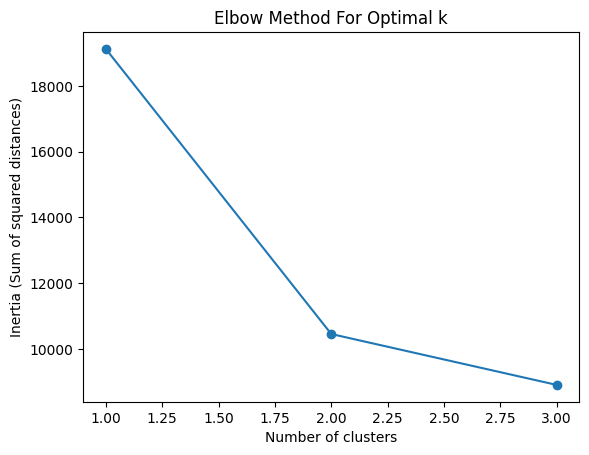

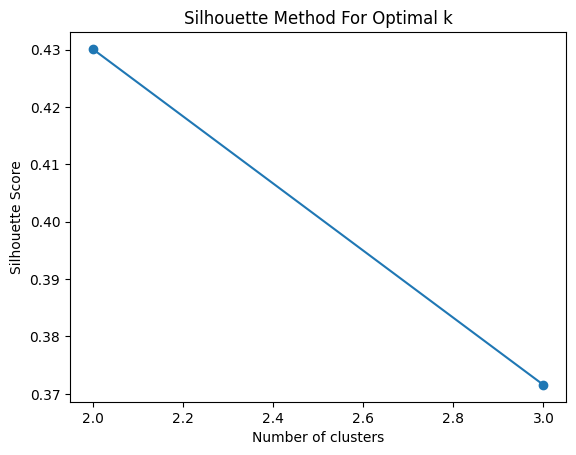

Fitting distributions:   0%|          | 0/38 [00:00<?, ?it/s]

number of segments: 153


Fitting distributions: 100%|██████████| 38/38 [00:00<00:00, 39.06it/s]
/home/lesi-nedo/miniforge3/envs/DM/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


number of chunks: 766


100%|██████████| 3067/3067 [00:00<00:00, 136658.42it/s]

Feature importance:
Length: 0.482
Points: 0.136
Startlist_Quality: 0.032
Is_Tarmac: 0.119
Profile: 0.421

Sample predictions by segment:
                   climb_total_predicted       prediction_confidence
                                    mean count                  mean
segment                                                             
L_M_Fall_Low_C4              3046.444444     9                   0.0
L_M_Spring_High_C4           3043.532256     4                   0.0
L_M_Spring_Low_C2            2467.854434     9                   0.0
L_M_Spring_Low_C4            2388.531926    23                   0.0
L_T_Fall_High_C1             3862.555295    11                   0.0

Metrics:
RMSE: 31.04 meters
R²: 0.492
MAE: 752.31 meters
MSE: 963.56


In [92]:
df_test = races_agg[races_agg['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']
df_test.loc[random_indices, 'climb_total'] = np.nan


local_normal_features = normal_features.copy()
# del local_normal_features['points']
del local_normal_features['cyclist_age']
# del local_normal_features['startlist_quality']
del local_normal_features['position']

predictions, stats_races = predict_feature_density(
    df_test, segmentation_features=local_normal_features, n_clusters_final=3, feature_to_predict='climb_total'
)


print_density_info(stats_races, predictions, y_test, 'climb_total')

del df_test



### Explanation of Visualization Code

The following code performs the following tasks:

1. **Assigns True Values to Predictions**:
    - The `climb_total` values for the randomly selected indices are assigned back to the `predictions` DataFrame.

2. **Creates Prediction Visualizations**:
    - The `create_prediction_visualizations` function is called to generate various visualizations for the `climb_total` predictions. This includes distribution plots, scatter plots, and error analysis.

3. **Creates Segment Analysis**:
    - The `create_segment_analysis` function is called to generate visualizations for segment analysis. This includes segment size distribution, confidence distribution, and prediction range by segment.

4. **Interactive Analysis**:
    - The commented-out `%matplotlib inline` and `plot_interactive_analysis` lines indicate that the code can be used for interactive analysis within a Jupyter notebook. Uncommenting these lines would enable inline plotting and interactive analysis of the predictions.


Length true data: 613
Length predicted data: 613
Mean true data: 2267.773246329527
Mean predicted data: 2470.316642791229
STD of true data: 1353.0139386224375
STD of predicted data: 1154.052346376018


/tmp/ipykernel_768474/3258177946.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


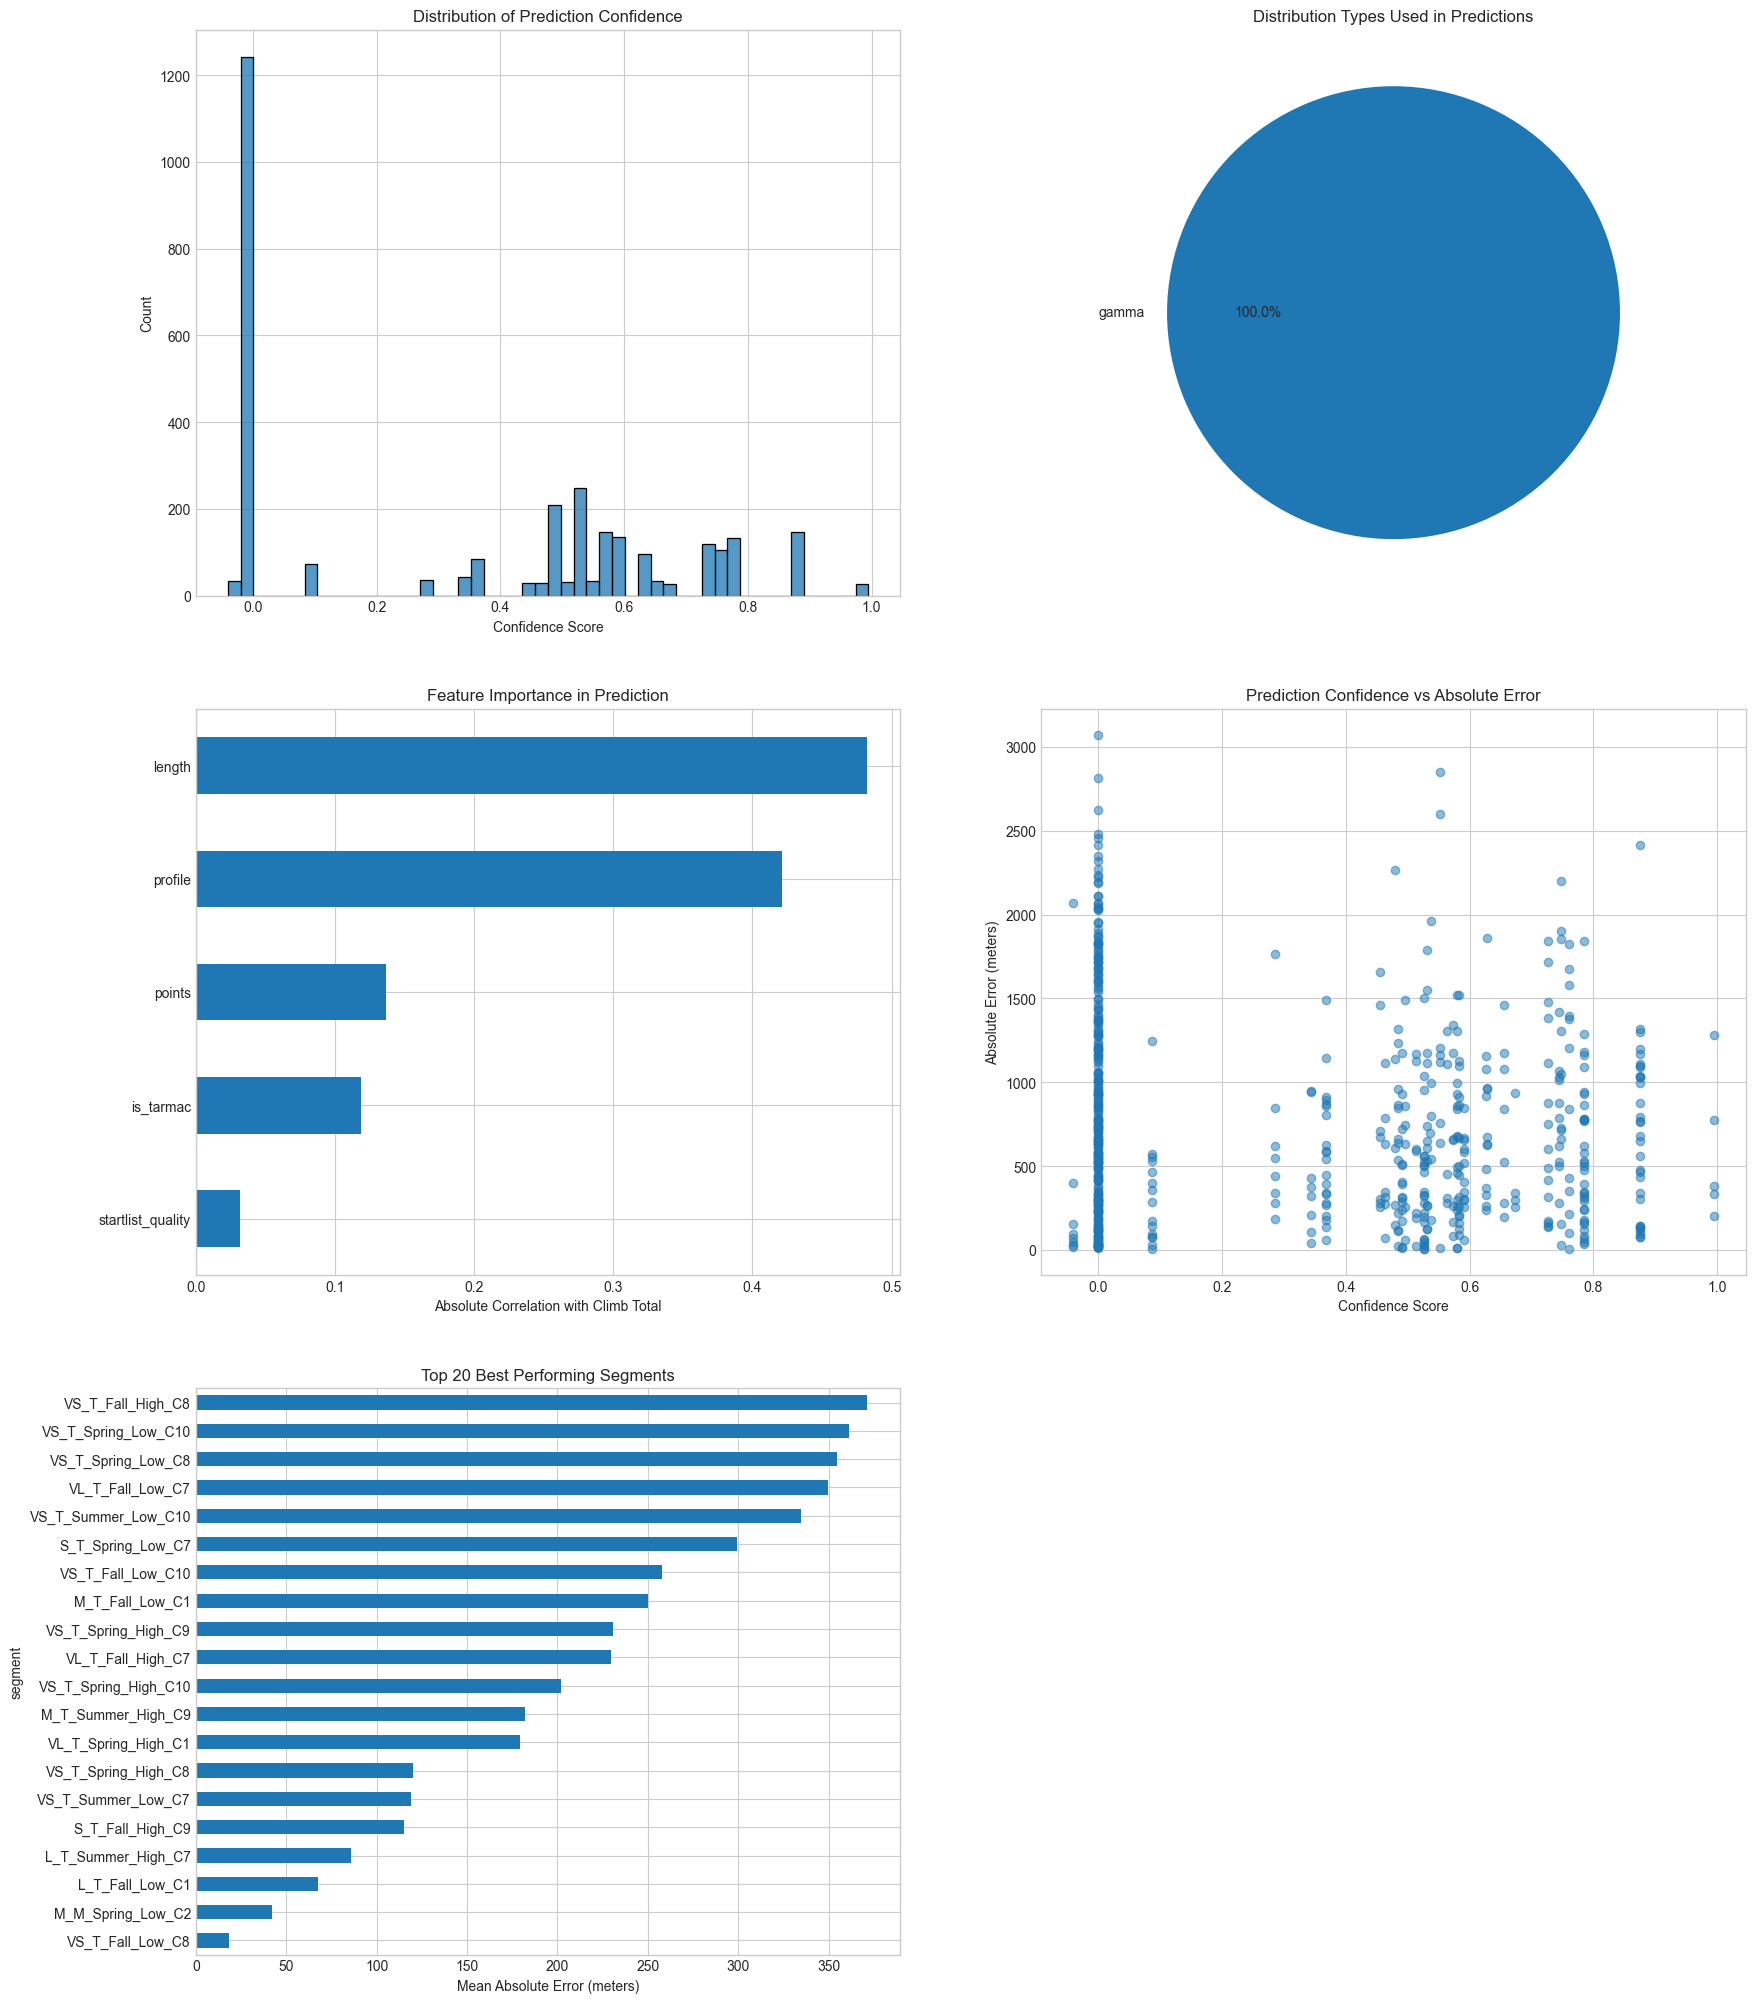

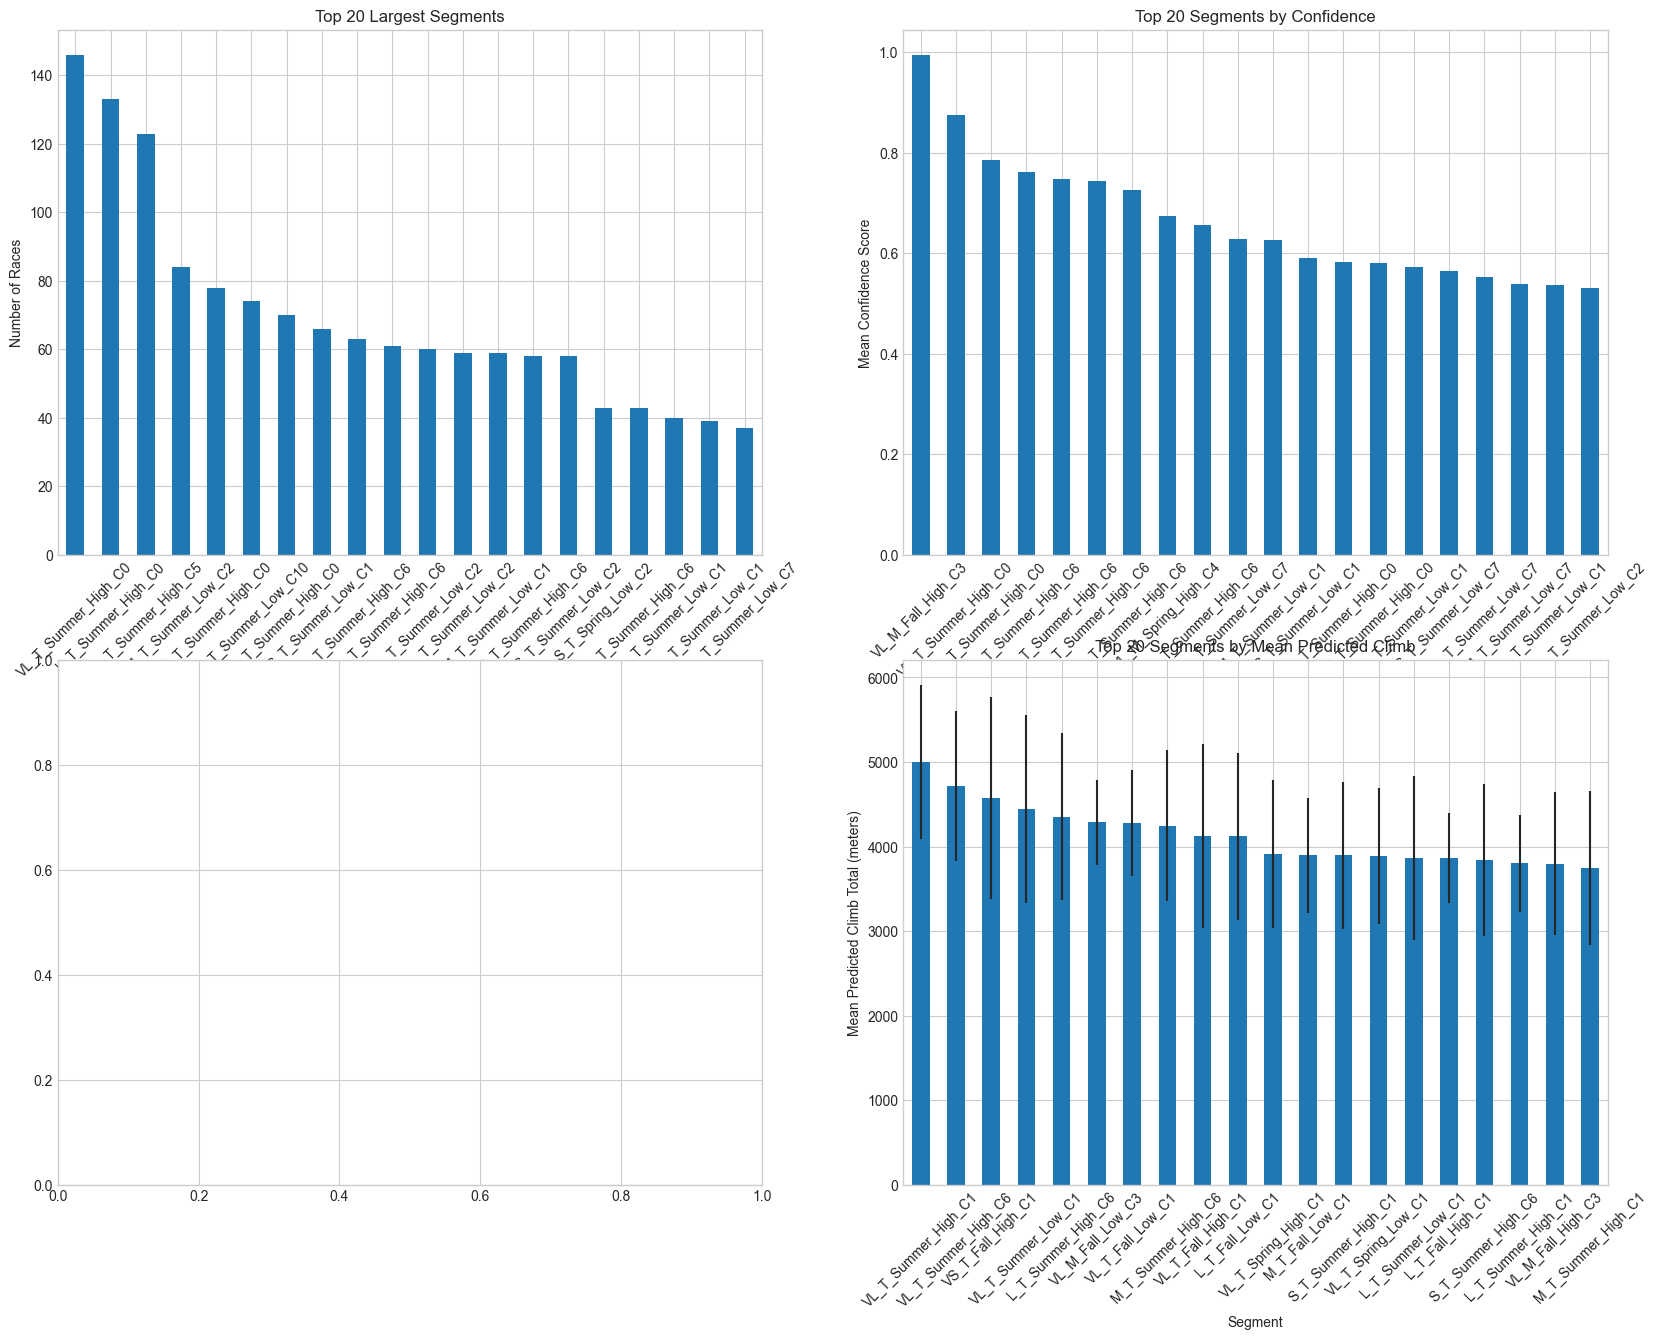

In [93]:


# Create all visualizations
predictions.loc[random_indices, 'climb_total'] = y_test
create_prediction_visualizations(predictions, y_test, stats_races, feature_name="climb_total")
create_segment_analysis(predictions, feature_name='climb_total')

# For interactive analysis in Jupyter notebook:
# %matplotlib inline
# plot_interactive_analysis(predictions)


### Distribution and Prediction Analysis

The distribution plot shows significant mismatch between actual and predicted values:

- Predicted values have a strong peak around 0-1000 meters.
- Actual values show a more spread out, multi-modal distribution.
- This suggests the model is oversimplifying the predictions.

### Actual vs Predicted Plot

Shows concerning patterns:

- Strong horizontal banding/striping.
- Poor alignment with the perfect prediction line.
- Systematic underprediction for higher values.
- Multiple distinct prediction bands suggesting the model might be discretizing its outputs.

### Feature Importance

Top influential features:

- Profile (~0.45 correlation)
- Length (~0.43 correlation)
- Startlist score per km (~0.38 correlation)

Less important features:

- Adjusted delta
- Is_tarmac
- Points
- Lower correlations (<0.1) for season, startlist_quality, team_present, and cyclist_age

### Prediction Confidence vs Error

Concerning relationship:

- Higher confidence scores generally associated with larger absolute errors.
- Wide spread of errors across all confidence levels.
- Many high-confidence predictions (0.5-0.7) show large errors (2000-6000 meters).

### Distribution of Prediction Confidence

Bimodal distribution:

- Large spike at 0.0 (very low confidence).
- Secondary peak around 0.6 (moderate-high confidence).
- Suggests the model is either very uncertain or possibly overconfident.

### Distribution Types

- Overwhelmingly gamma distribution (97.4%).
- Small portion of beta distribution (2.6%).
- This suggests the model expects right-skewed, positive-only predictions.

### Key Problems Identified

- Poor calibration between confidence and accuracy.
- Systematic underprediction of higher values.
- Discretization of predictions (banding).
- Mismatch between predicted and actual distributions.
- Overconfidence in some predictions despite large errors.

### Recommendations

- Investigate the cause of prediction banding.
- Recalibrate the confidence scoring system.
- Consider ensemble methods to better handle the multi-modal distribution.
- Feature engineering to better capture the relationship between profile/length and climb total.
- Consider using different evaluation metrics that better capture the multi-modal nature of the data.

This analysis suggests the model needs significant improvement, particularly in handling the full range of climb totals and providing more reliable confidence estimates.

### Explanation of KNN Imputation Code

This code performs the following tasks:

1. **Imports and Setup**:
    - Imports necessary libraries including `KNNImputer` from `sklearn`, `logging`, and `warnings`.

2. **Feature Engineering**:
    - The `engineer_features` function processes date features and calculates derived features such as `points_per_km` and `season_score`.

3. **Predict Climb Total**:
    - The `predict_climb_total` function predicts missing `climb_total` values using KNN imputation.
    - Validates input data and ensures all required columns are present.
    - Engineers additional features and updates the feature set.
    - Applies KNN imputation to predict missing values.
    - Calculates and logs validation metrics if `y_true` is provided.

4. **Example Usage**:
    - Demonstrates the usage of the `predict_climb_total` function on a test dataset.
    - Randomly selects 20% of the data, sets their `climb_total` values to NaN, and predicts these values.
    - Prints the calculated metrics including RMSE, R², MAE, and MSE.

In [96]:
from sklearn.impute import KNNImputer
import logging
from typing import Tuple, Optional, Dict
import warnings



def predict_feature_knnimp(
    df: pd.DataFrame,
    features: Dict[str, Dict[str, str]],
    feature_to_predict: str,
    type: str,
    y_true: pd.Series | None = None,
    n_neighbors: int = 5,
    min_samples_required: int = 100,
    return_metrics: bool = True
) -> Tuple[pd.DataFrame, Optional[Dict[str, float]]]:
    """
    Predicts missing climb_total values in cycling race data using KNN imputation
    with advanced feature engineering and validation.
    """
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    warnings.filterwarnings('ignore', category=UserWarning)
    
    try:
        # Validate input data
        missing_race_cols = [col for col in features if col not in df.columns]
        if missing_race_cols:
            raise ValueError(f"Missing required columns. Races: {missing_race_cols}")

        logger.info("Starting prediction process...")
        
        
        
        features = {**features, feature_to_predict: {'type': type}}
        
        X = df[features.keys()].copy()
        
        if len(X) < min_samples_required:
            raise ValueError(f"Insufficient data: {len(X)} samples, {min_samples_required} required")
        
        
        
        # Apply KNN imputation
        logger.info("Applying KNN imputation...")
        imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
        X_imputed = imputer.fit_transform(X)
        
    
        
        # Extract only the `feature_to_predict`` column from predictions
        feature_to_pred_idx = list(X.columns).index(feature_to_predict)
        predicted_feature = X_imputed[:, feature_to_pred_idx]

        y_pred = pd.Series(predicted_feature, index=X.index, name=f'{feature_to_predict}_predicted')
        
        
        # Calculate metrics if requested
        metrics = None
        if return_metrics and y_true is not None:
            logger.info("Calculating validation metrics...")
            y_pred = y_pred.loc[y_true.index]  # Ensure we're comparing 1D arrays 
            logger.info(f"y_pred shape: {y_pred.shape}, y_true shape: {y_true.shape}")

            
            mse_con = mse(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mse_con)
            mae = np.mean(np.abs(y_true - y_pred))
            
            metrics = {
                'mse': round(mse_con, 2),
                'rmse': round(rmse, 2),
                'mae': round(mae, 2),
                'r2': round(r2, 2),
                'samples_used': len(y_pred),
            }
            errors_visualization(y_true, y_pred, feature_to_predict) 
            logger.info(f"Validation metrics: RMSE={rmse:.2f}, R2={r2:.2f}")
        else:
            logger.info("Prediction complete")
        
        return metrics
    
    except Exception as e:
        logger.error(f"Error in prediction process: {str(e)}")
        raise RuntimeError(f"Prediction failed: {str(e)}")


INFO:__main__:Starting prediction process...
INFO:__main__:Applying KNN imputation...
INFO:__main__:Calculating validation metrics...
INFO:__main__:y_pred shape: (613,), y_true shape: (613,)
INFO:__main__:Validation metrics: RMSE=31.03, R2=0.55



Metrics:
MSE: 962.92
RMSE: 31.03
MAE: 735.66
R2: 0.55
SAMPLES_USED: 613


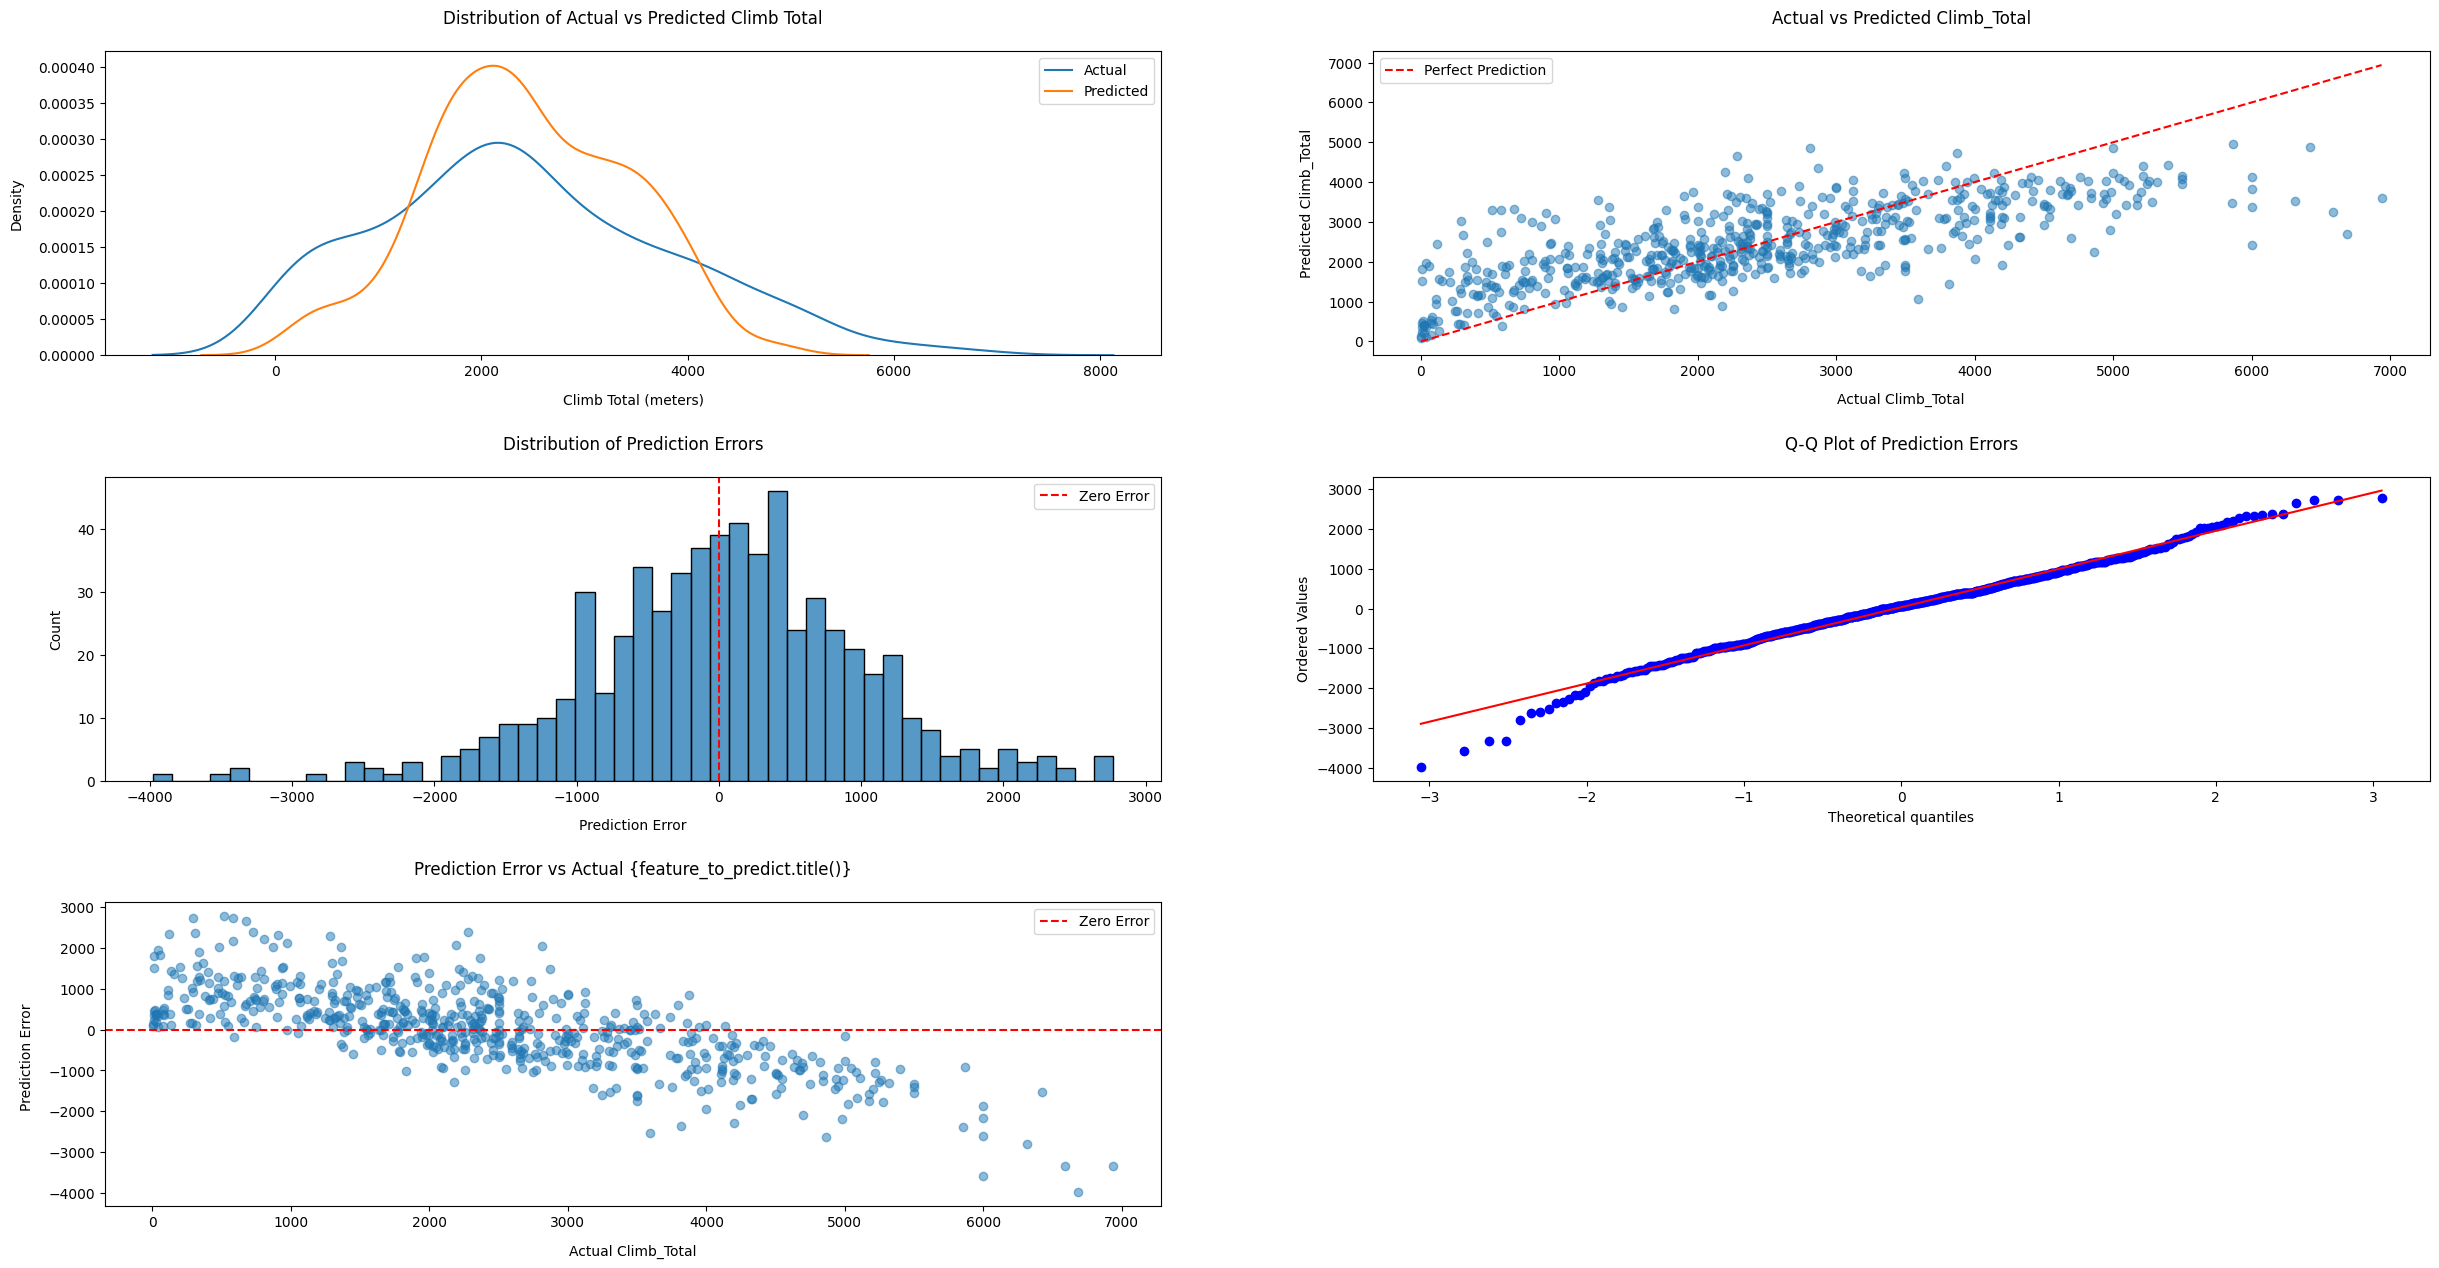

In [14]:

df_test = races_agg[races_agg['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']

df_test.loc[random_indices, 'climb_total'] = np.nan

metrics = predict_feature_knnimp(df_test, n_neighbors=7, feature_to_predict='climb_total', type='numeric', y_true=y_test, features=pred_features)

metrics

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")

del df_test

### Overall Model Performance

The model uses KNN imputation to predict missing `climb_total` values. The plots show relatively good prediction accuracy, with an R² score indicated in the metrics. Most predictions fall reasonably close to the "Perfect Prediction" line in the second plot.

### Error Analysis (from the plots)

#### a) Prediction Error vs Actual (Image 1):

- The errors appear roughly symmetrically distributed around zero (red dashed line).
- The spread of errors increases with larger climb totals.
- Most errors fall within ±1000 meters.
- There's some heteroscedasticity - larger climb totals show more variance in predictions.
- A few notable outliers exist, especially for climbs over 5000m.

#### b) Actual vs Predicted Plot (Image 2, top):

- Shows a strong positive correlation between predicted and actual values.
- Points cluster well around the "Perfect Prediction" line (red dashed).
- More scatter/variance at higher climb totals.
- The model performs best in the 1000-4000m range.
- Some underprediction tendency for very high climb totals (>5000m).

#### c) Q-Q Plot (Image 2, bottom):

- The blue dots following the red line indicate normally distributed errors.
- Some deviation at the tails suggests slightly heavier tails than normal distribution.
- Small departures at extreme values, especially below -2000m.

#### d) Distribution Plots (Image 3):

- **Top**: Shows the distribution of actual (blue) vs predicted (orange) climb totals.
    - The model captures the general shape of the distribution.
    - Slight overconcentration around 2000-3000m in predictions.
    - Some underestimation of extreme values.
- **Bottom**: Distribution of prediction errors.
    - Approximately normal distribution centered near zero.
    - Slightly right-skewed.
    - Most errors fall within ±1000m.
    - Few outliers beyond ±2000m.

### Overall Assessment

- The model performs reasonably well for most climb totals.
- More accurate for moderate climbs (1000-4000m).
- Less reliable for extreme values, especially very high climbs.
- Errors are generally well-behaved (roughly normal distribution).
- The model could potentially be improved for handling extreme values and reducing heteroscedasticity.


## Conclusion

Based on the analysis above, I decide to use the Voting Regressor to fill the missing values in `climb_total`.


In [137]:
climb_total_pred_v1 = climb_total_pred.apply(lambda x: round(x, 0))

races_v1 = races_.copy()

temp_obj = races_v1.loc[races_v1['climb_total'].isna(), '_url'].map(climb_total_pred_v1)

# Update the 'climb_total' column in races_v1 only for NaN entries
races_v1.loc[temp_obj.index, 'climb_total'] = temp_obj

print(f"Number of missing values in climb_total: {races_v1['climb_total'].isna().sum()}")

Number of missing values in climb_total: 0



## Now we will fill the `profile` missing values.


### Preparing the Dataset to Predict the `profile` Missing Features

In the next cell, we will prepare the dataset to predict the missing values in the `profile` feature. This involves data preprocessing, feature engineering, and handling missing values to ensure the dataset is ready for model training and prediction.

In [138]:
races_prof = races_climb.drop(columns=['profile']).copy()

# Update the 'climb_total' column with true values and predicted values for NaN entries
races_prof['climb_total'] = races_v1['climb_total']

# Updating the profile column with the original  values
races_prof['profile'] = races_['profile']
print(f"Number of missing values in climb: {races_prof['profile'].isna().sum()}")

# scaling the 'climb_total' column
preprocess_helper_scaler(races_prof, {'climb_total': {'type': 'numeric'}})

races_prof.sample(frac=0.3).head(10)

del races_climb
del races_agg

Number of missing values in climb: 148194


In [139]:
normal_features_prof = normal_features.copy()
del normal_features_prof['profile']
normal_features_prof['climb_total'] = {'type': 'numeric', 'agg': 'first'}
FEATURES_PROF = {**normal_features_prof, **engineered_features}

pred_features_prof = {name: {'type': props['type']} for name, props in FEATURES_PROF.items()}

agg_dict_prof = {name: props['agg'] for name, props in FEATURES_PROF.items()}
agg_dict_prof['date'] = 'first'
agg_dict_prof['profile'] = 'first'

races_agg_prof = races_prof.groupby(["_url"]).agg(agg_dict_prof)

races_agg_prof.sample(frac=0.4).head(10)


length    points  startlist_quality  \
_url                                                                    
volta-a-catalunya/2000/stage-2 -0.104983 -0.720915          -1.061943   
tour-de-france/1982/stage-20   -0.089490  0.197940           1.026938   
tour-de-suisse/1972/stage-2    -1.081038 -0.720915          -1.755609   
tour-de-france/2012/stage-1     0.483749  0.197940           1.581345   
tour-de-france/1995/stage-15    0.623185  0.197940           2.022769   
la-fleche-wallone/2002/result   0.483749  2.495077          -0.336746   
volta-a-catalunya/1995/stage-5 -0.053856 -0.720915          -0.956842   
vuelta-a-espana/2014/stage-5    0.204876 -0.169602           0.194013   
vuelta-a-espana/2000/stage-20  -0.647236 -0.169602          -0.315726   
tour-de-france/2010/prologue   -2.445965  0.197940           1.534050   

                                is_tarmac  position  cyclist_age  climb_total  \
_url                                                                            
volta-a-catalunya/2000/stage-2        1.0 -0.273108    -0.126115    -0.501604   
tour-de-france/1982/stage-20          1.0 -0.252448    -0.385501    -0.711499   
tour-de-suisse/1972/stage-2           1.0 -1.533334     0.133271    -0.600016   
tour-de-france/2012/stage-1           1.0  0.460303     0.392656     0.259554   
tour-de-france/1995/stage-15          1.0 -0.314426    -0.126115     2.812123   
la-fleche-wallone/2002/result         0.0  0.036784    -0.126115     0.157298   
volta-a-catalunya/1995/stage-5        1.0 -1.337070    -0.385501     0.228031   
vuelta-a-espana/2014/stage-5          1.0  0.501622    -0.126115    -0.148703   
vuelta-a-espana/2000/stage-20         1.0 -0.252448    -0.126115     0.025825   
tour-de-france/2010/prologue          1.0  0.449973     0.133271    -1.767893   

                                points_per_km  season_score  season  \
_url                                                                  
volta-a-catalunya/2000/stage-2      -0.298623      0.081679       2   
tour-de-france/1982/stage-20        -0.183735     -0.832939       2   
tour-de-suisse/1972/stage-2         -0.223067      0.057206       2   
tour-de-france/2012/stage-1         -0.226943     -0.292568       2   
tour-de-france/1995/stage-15        -0.235118     -0.690230       2   
la-fleche-wallone/2002/result        0.008073      1.130574       1   
volta-a-catalunya/1995/stage-5      -0.300974      0.007966       2   
vuelta-a-espana/2014/stage-5        -0.249505     -1.489766       2   
vuelta-a-espana/2000/stage-20       -0.176706     -1.703168       0   
tour-de-france/2010/prologue         3.767806     -0.317766       2   

                                team_presents  adjusted_delta  \
_url                                                            
volta-a-catalunya/2000/stage-2     -89.691672       -0.330402   
tour-de-france/1982/stage-20      -104.246288       -0.304437   
tour-de-suisse/1972/stage-2          0.607895       -0.332378   
tour-de-france/2012/stage-1         77.379239       -0.279576   
tour-de-france/1995/stage-15       -35.800374        0.419708   
la-fleche-wallone/2002/result      -53.431488       -0.165032   
volta-a-catalunya/1995/stage-5     -12.624159       -0.332378   
vuelta-a-espana/2014/stage-5       118.110380       -0.100239   
vuelta-a-espana/2000/stage-20      -95.234627        0.180043   
tour-de-france/2010/prologue       103.806326        0.391379   

                                              date  profile  
_url                                                         
volta-a-catalunya/2000/stage-2 2000-06-16 03:52:47      NaN  
tour-de-france/1982/stage-20   1982-07-24 04:22:21      1.0  
tour-de-suisse/1972/stage-2    1972-06-17 02:33:07      NaN  
tour-de-france/2012/stage-1    2012-07-01 04:58:19      3.0  
tour-de-france/1995/stage-15   1995-07-18 06:20:48      5.0  
la-fleche-wallone/2002/result  2002-04-17 04:42:04      3.0  
volta-a-catalunya/1995/stage-5 1995-06-20 03:58:09    

### Running `compare_algorithms` for Predicting `profile` Missing Values

In the next cell, we will run the `compare_algorithms` function to get the best model for predicting `profile` missing values.


Training Random Forest...
Random Forest Results:
RMSE: 0.88 meters
R²: 0.719
CV RMSE: 0.86 ± 0.04 meters

Training Gradient Boosting...
Gradient Boosting Results:
RMSE: 0.89 meters
R²: 0.707
CV RMSE: 0.85 ± 0.03 meters

Training XGBoost...
XGBoost Results:
RMSE: 0.89 meters
R²: 0.713
CV RMSE: 0.85 ± 0.03 meters

Training Huber...
Huber Results:
RMSE: 1.05 meters
R²: 0.436
CV RMSE: 0.96 ± 0.13 meters

Training Linear Regression...
Linear Regression Results:
RMSE: 1.03 meters
R²: 0.485
CV RMSE: 0.97 ± 0.12 meters

Training Ridge...
Ridge Results:
RMSE: 1.02 meters
R²: 0.488
CV RMSE: 0.97 ± 0.12 meters

Training Lasso...
Lasso Results:
RMSE: 1.21 meters
R²: 0.016
CV RMSE: 1.48 ± 0.13 meters

Training KNeighborsRegressor...
KNeighborsRegressor Results:
RMSE: 1.08 meters
R²: 0.374
CV RMSE: 1.19 ± 0.10 meters

Training HistGradientBoostingRegressor...
HistGradientBoostingRegressor Results:
RMSE: 0.89 meters
R²: 0.707
CV RMSE: 0.86 ± 0.03 meters

Training VotingRegressor...
VotingRegressor R

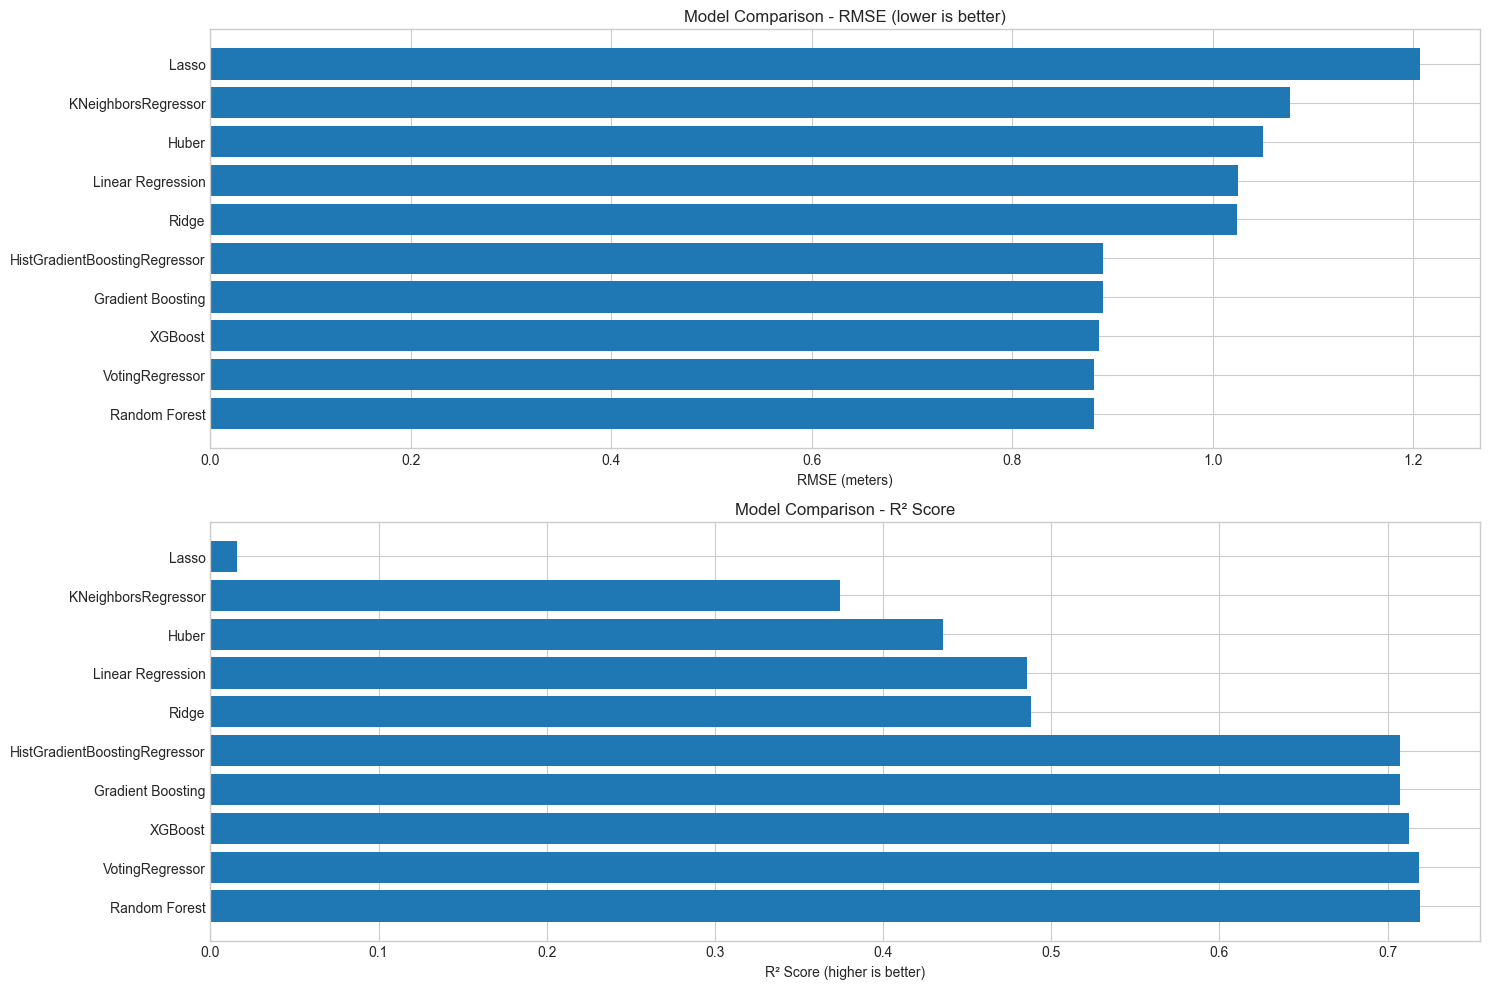

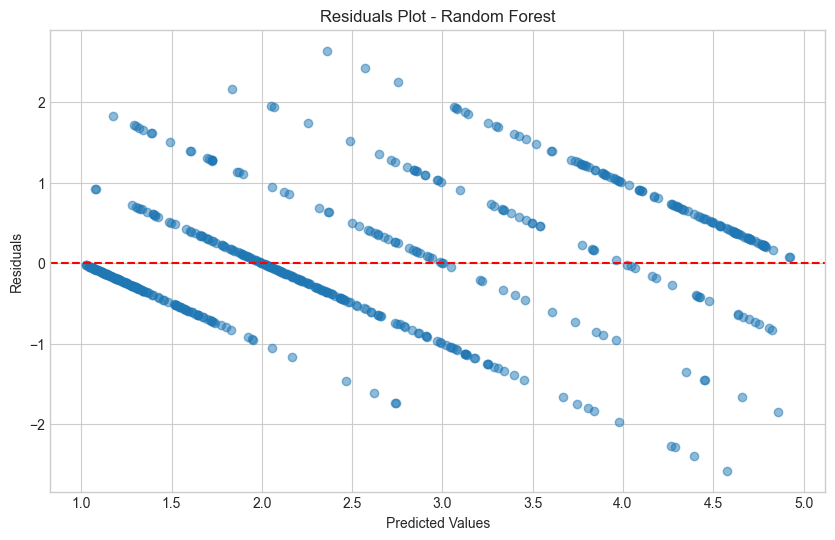


Summary of all models:
                                   RMSE        R²   CV RMSE  CV RMSE Std
Random Forest                  0.881637  0.718957  0.855946     0.040516
VotingRegressor                0.881742  0.718822  0.846088     0.030092
XGBoost                        0.886360  0.712885  0.851388     0.029618
Gradient Boosting              0.890603  0.707347  0.849889     0.031747
HistGradientBoostingRegressor  0.890764  0.707136  0.864749     0.028991
Ridge                          1.024226  0.488084  0.971424     0.116543
Linear Regression              1.025539  0.485454  0.973221     0.119392
Huber                          1.049524  0.435602  0.964425     0.130637
KNeighborsRegressor            1.077004  0.374130  1.191809     0.095916
Lasso                          1.206133  0.015545  1.479572     0.133635
Visualizations for the best model:


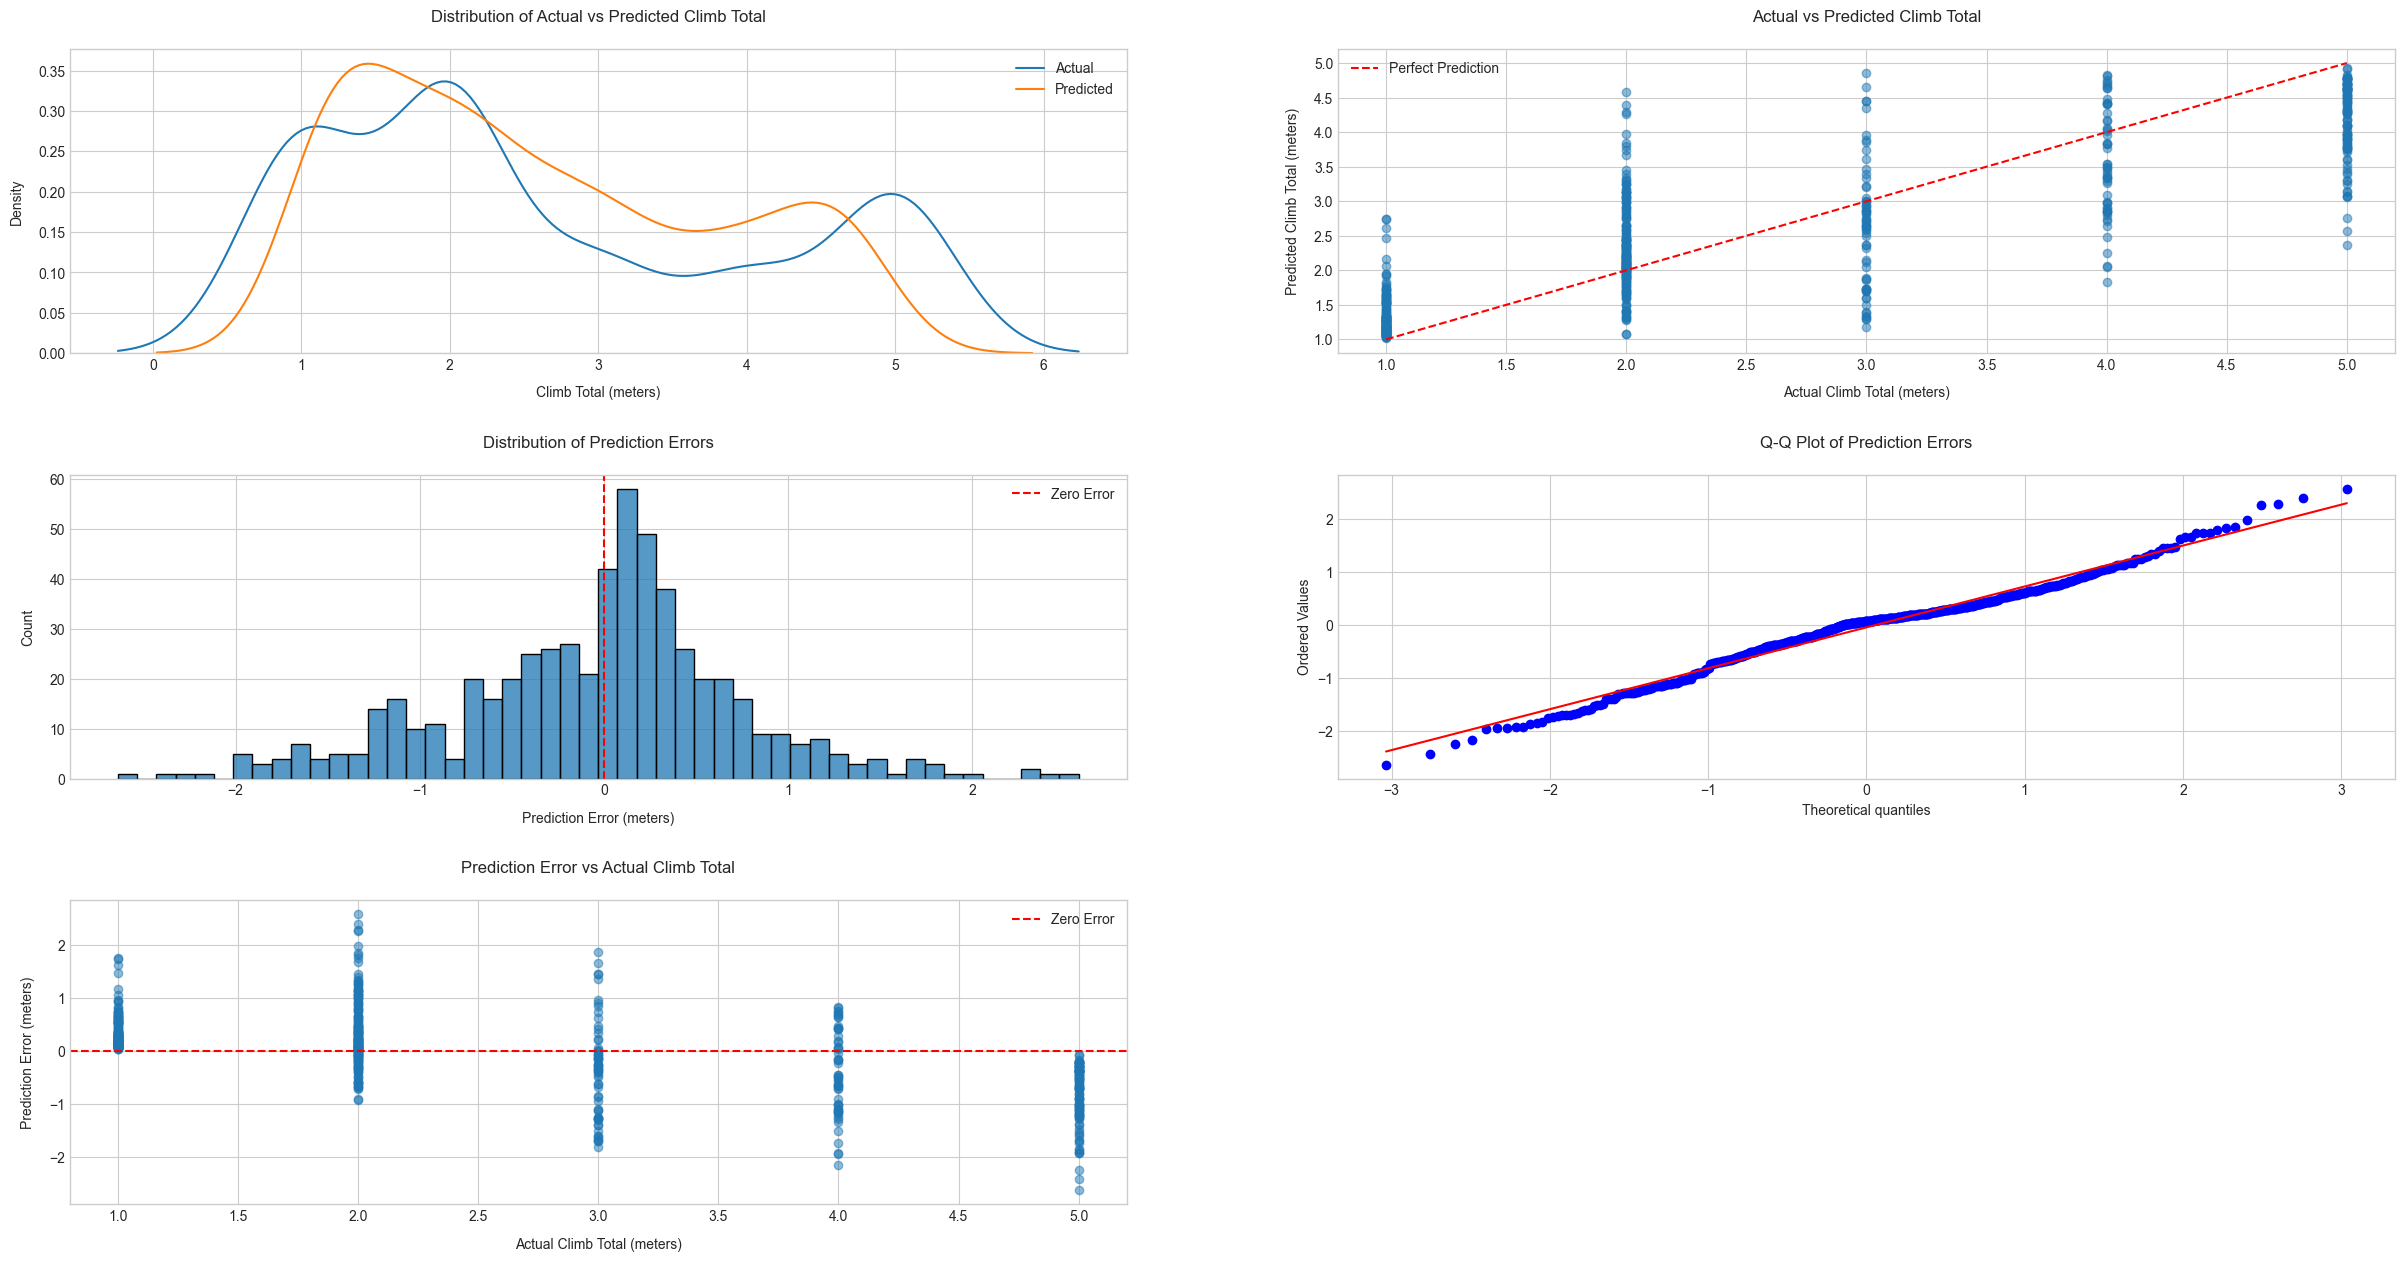

In [31]:
results_prof, summary_prof, profile_pred =  compare_algorithms(races_agg_prof, "profile", features=pred_features_prof)

### Running `predict_feature_density` algorithm for predicting `profile` missing values



 Feature statistics before imputation:
length: 0 missing (0.00%)
points: 0 missing (0.00%)
startlist_quality: 0 missing (0.00%)
is_tarmac: 0 missing (0.00%)
position: 0 missing (0.00%)
cyclist_age: 0 missing (0.00%)
climb_total: 0 missing (0.00%)


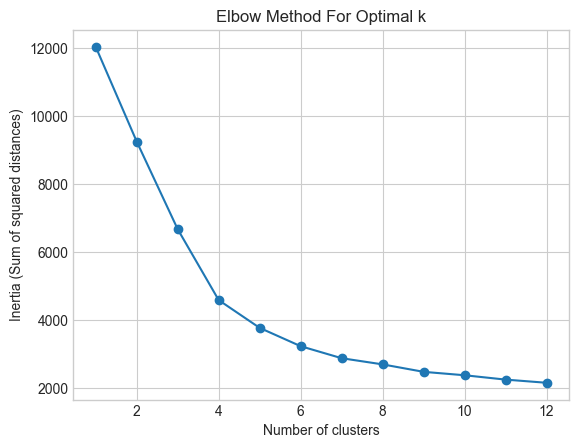

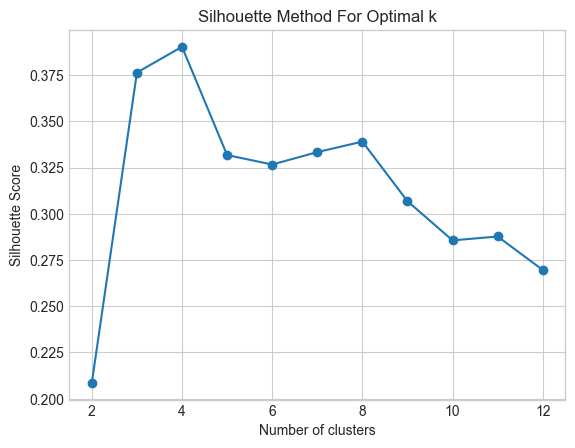

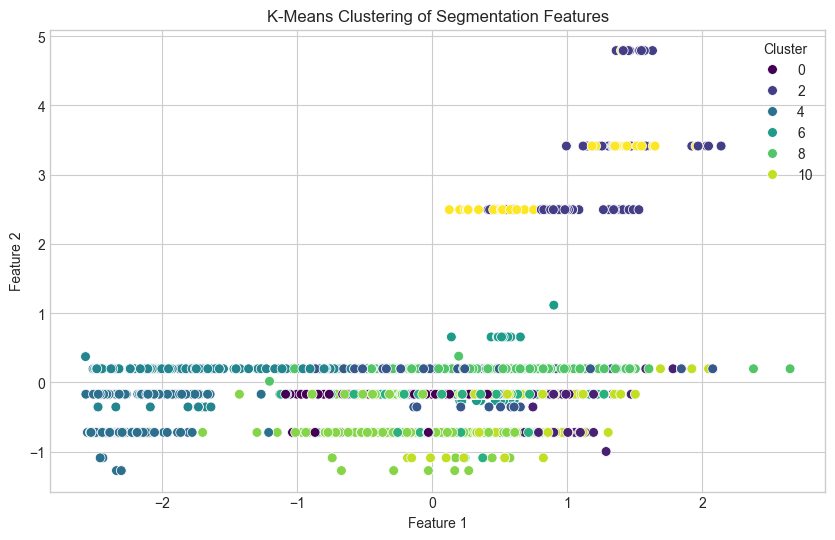

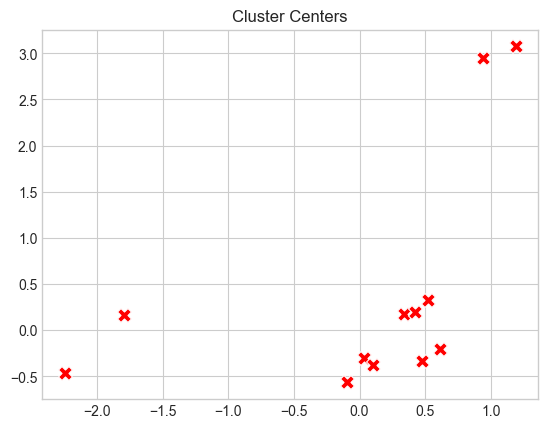

number of segments: 161


100%|██████████| 2873/2873 [00:00<00:00, 143771.82it/s]

Feature importance:
{'length': np.float64(0.06454283012800104), 'points': np.float64(0.12854386834926382), 'startlist_quality': np.float64(0.07148640357300617), 'is_tarmac': np.float64(0.1070764112898784), 'position': np.float64(0.04504439028373885), 'cyclist_age': np.float64(0.036090324375590434), 'climb_total': np.float64(0.6135965654841313)}

Sample predictions by segment:
                    profile_predicted       prediction_confidence
                                 mean count                  mean
segment                                                          
L_M_Fall_Low_C11             2.687045    14                   0.0
L_M_Fall_Low_C2              2.637299     7                   0.0
L_M_Spring_High_C11          2.557152     2                   0.0
L_M_Spring_High_C2           2.483869    10                   0.0
L_M_Spring_Low_C11           2.619929    22                   0.0

Metrics:
RMSE: 1.21 meters
R²: -0.012
MAE: 1.12 meters
MSE: 1.47


In [210]:


den_alg_df = races_agg_prof[races_agg_prof['profile'].notna()].copy()
random_indices = den_alg_df.sample(frac=0.2).index
y_test = den_alg_df.loc[random_indices, 'profile']
den_alg_df.loc[random_indices, 'profile'] = np.nan

local_normal_features_prof = normal_features_prof.copy()

predictions_prof, stats_races_prof = predict_feature_density(
    den_alg_df, segmentation_features=local_normal_features_prof, n_clusters_final=4, feature_to_predict='profile'
)

# View feature importance
print("Feature importance:")
print(stats_races_prof['feature_importance'])

# View segments and their predictions
print("\nSample predictions by segment:")
predictions_summary = predictions_prof.groupby('segment').agg({
    'profile_predicted': ['mean', 'count'],
    'prediction_confidence': 'mean'
}).head()
print(predictions_summary)

print("\nMetrics:")
mse_score = mse(y_test, predictions_prof['profile_predicted'].loc[y_test.index])
r2 = r2_score(y_test, predictions_prof['profile_predicted'].loc[y_test.index])
rmse = np.sqrt(mse_score)
mae = np.mean(np.abs(y_test - predictions_prof['profile_predicted'].loc[y_test.index]))
print(f"RMSE: {rmse:.2f} meters")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f} meters")
print(f"MSE: {mse_score:.2f}")
del den_alg_df

Length true data: 575
Length predicted data: 575
Mean true data: 2.5721739130434784
Mean predicted data: 2.45940100562922
STD of true data: 1.458338264035352
STD of predicted data: 1.1033677322755655


/tmp/ipykernel_441495/3258177946.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


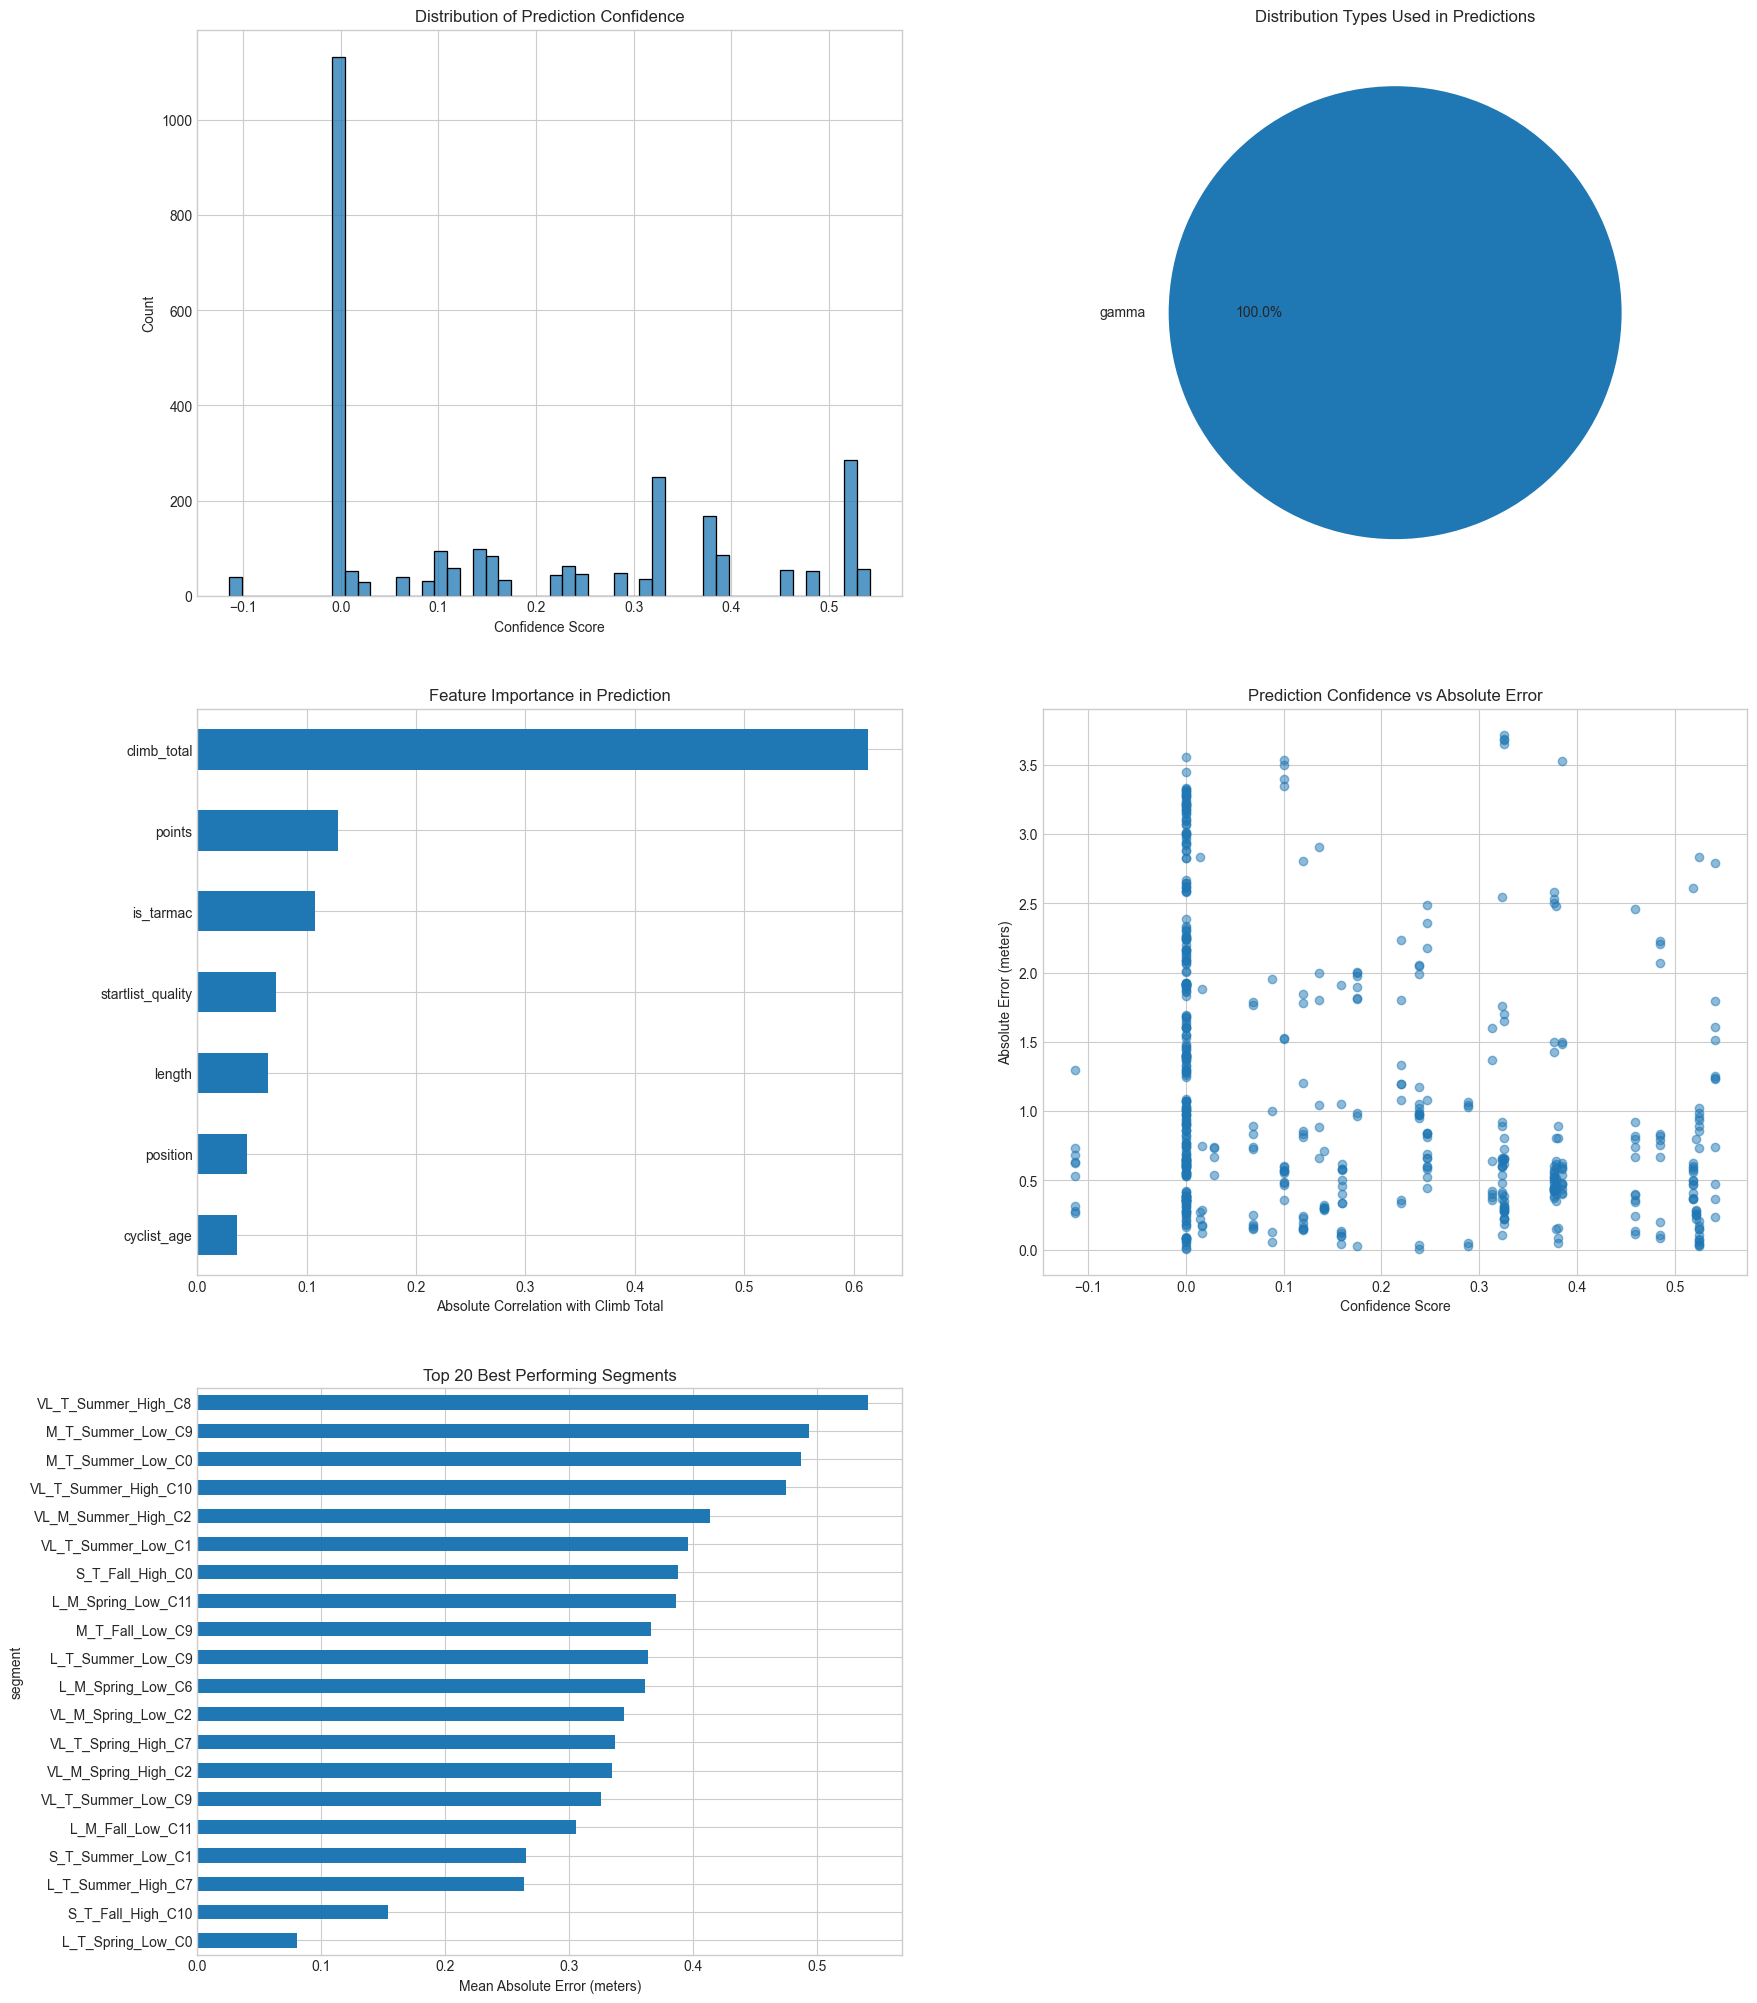

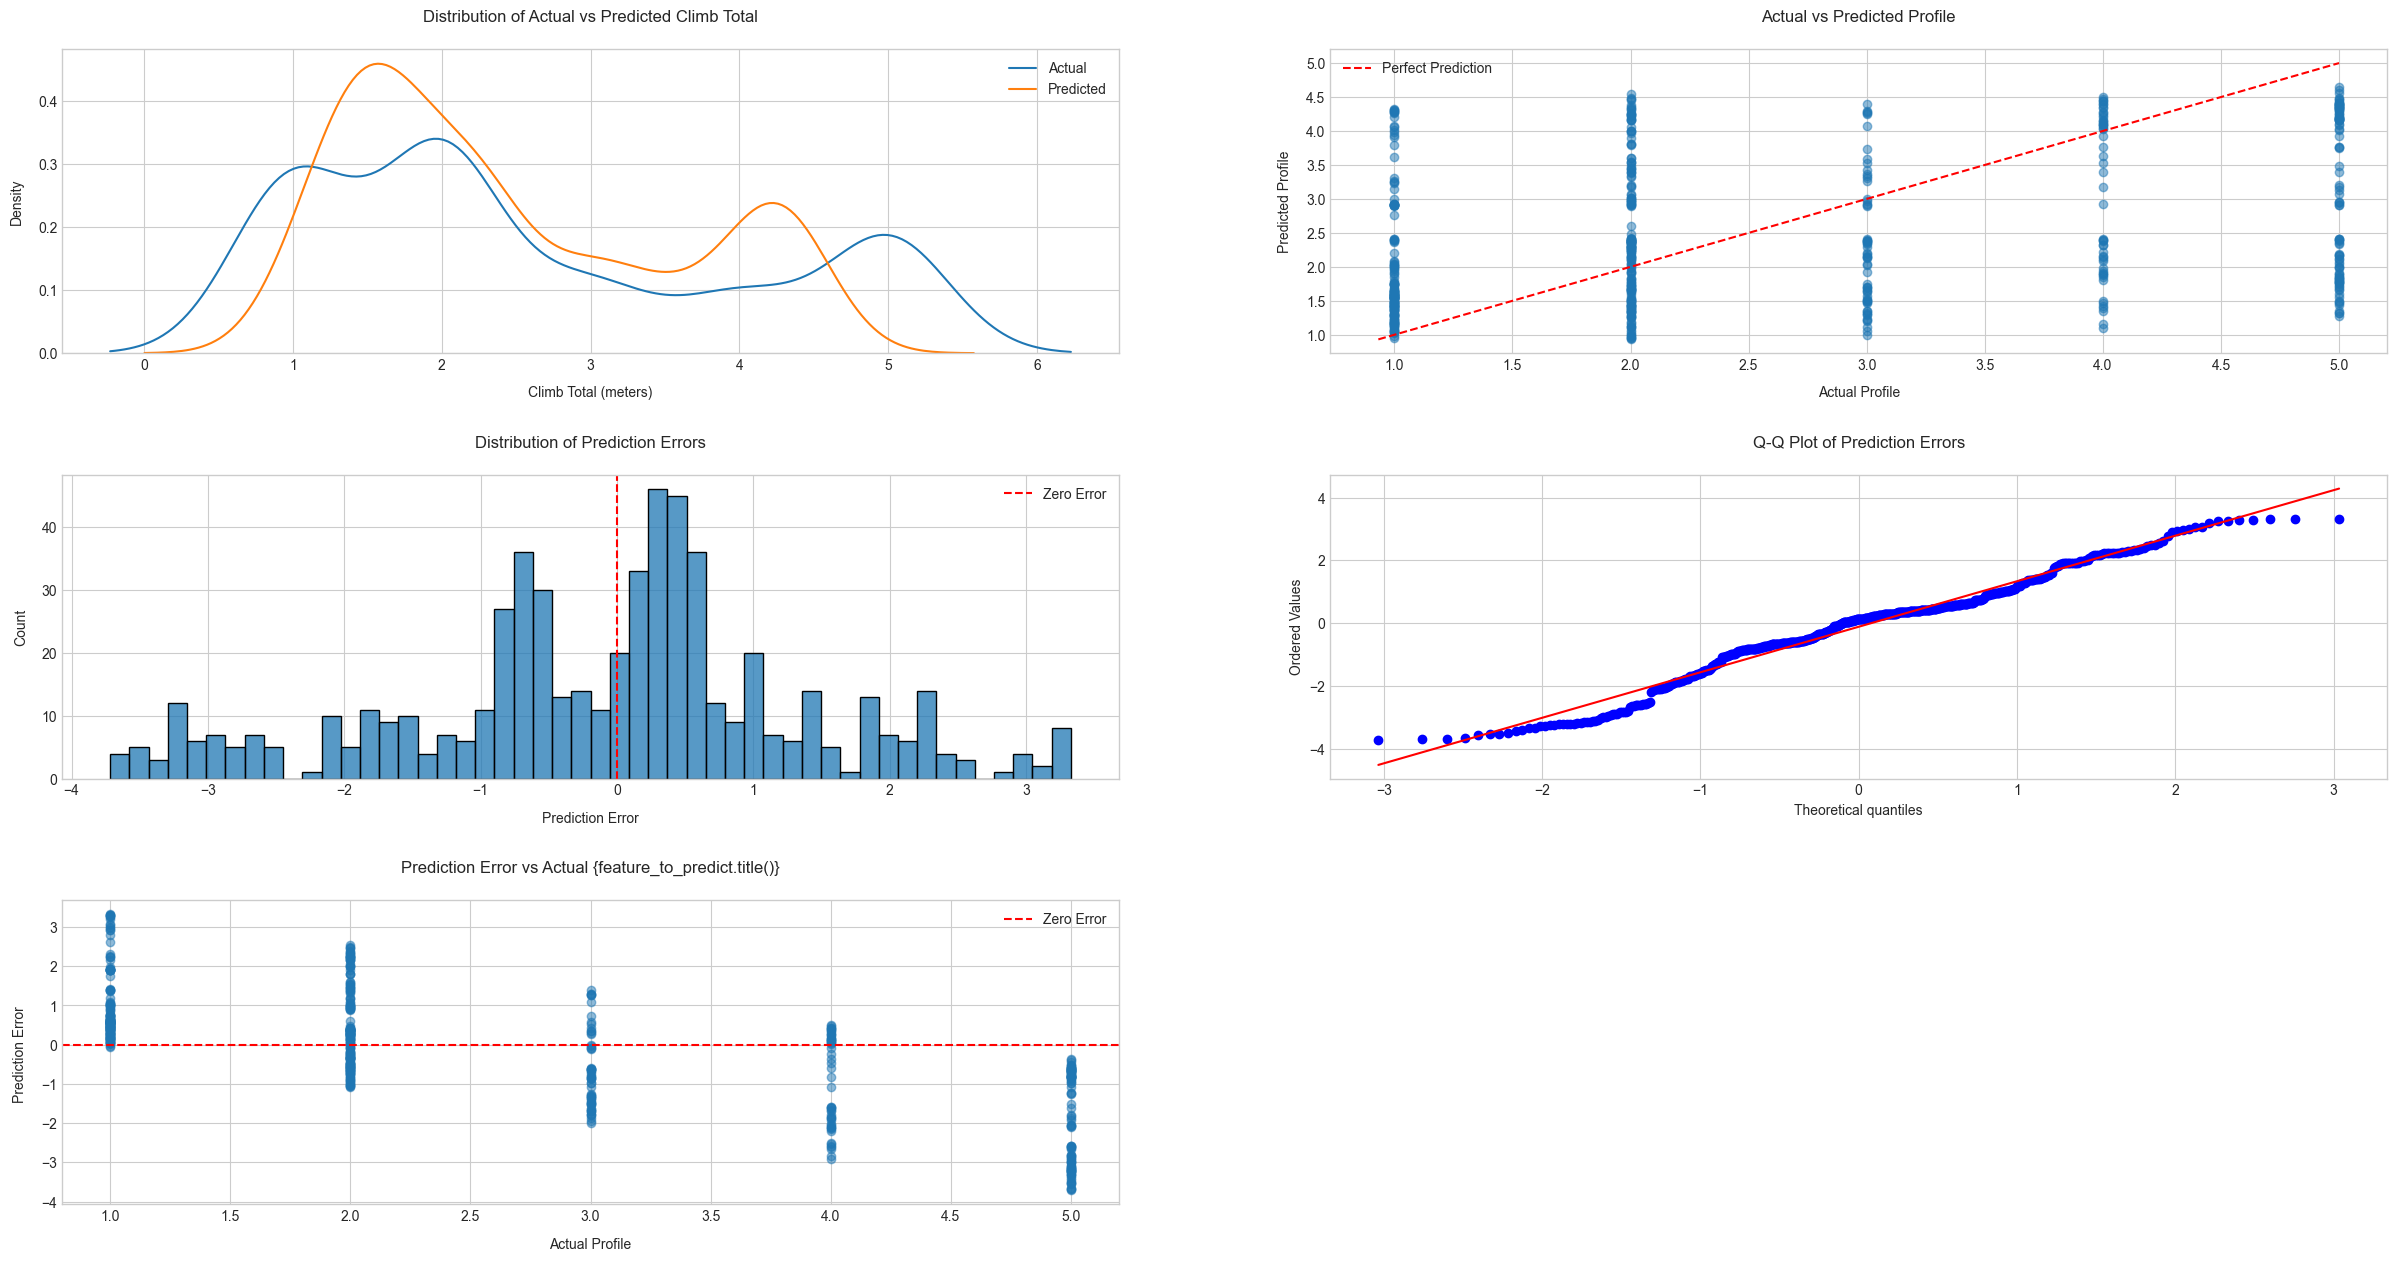

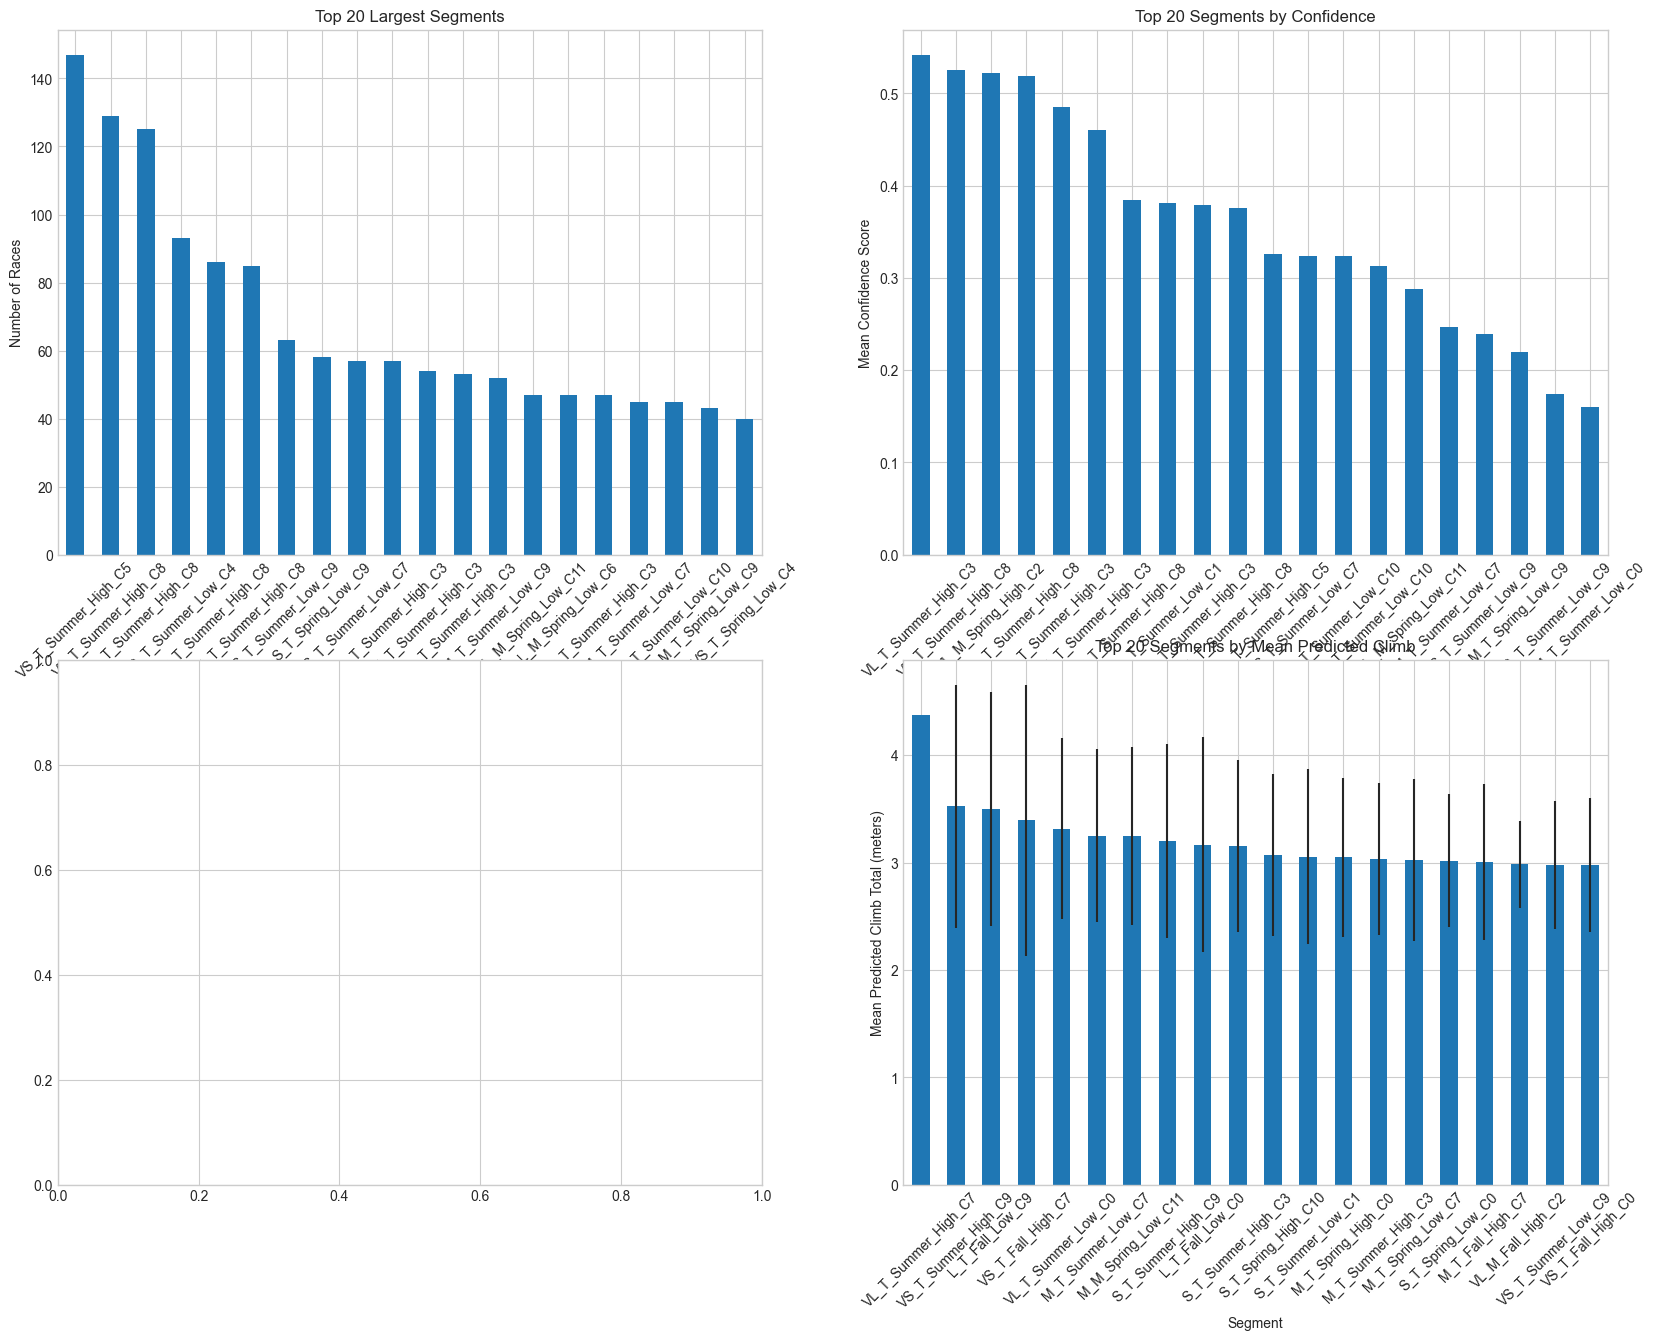

In [211]:

# Create all visualizations
predictions_prof.loc[random_indices, 'profile'] = y_test
create_prediction_visualizations(predictions_prof, y_test, stats_races_prof, feature_name="profile")
create_segment_analysis(predictions_prof, feature_name='profile')

# For interactive analysis in Jupyter notebook:
# %matplotlib inline
# plot_interactive_analysis(predictions)

del predictions_prof

### Running `predict_feature_knnimp` algorithm for predicting `profile` missing values

INFO:__main__:Starting prediction process...
INFO:__main__:Applying KNN imputation...
INFO:__main__:Calculating validation metrics...
INFO:__main__:y_pred shape: (575,), y_true shape: (575,)
INFO:__main__:Validation metrics: RMSE=1.09, R2=0.38



Metrics:
MSE: 1.18
RMSE: 1.09
MAE: 0.89
R2: 0.38
SAMPLES_USED: 575


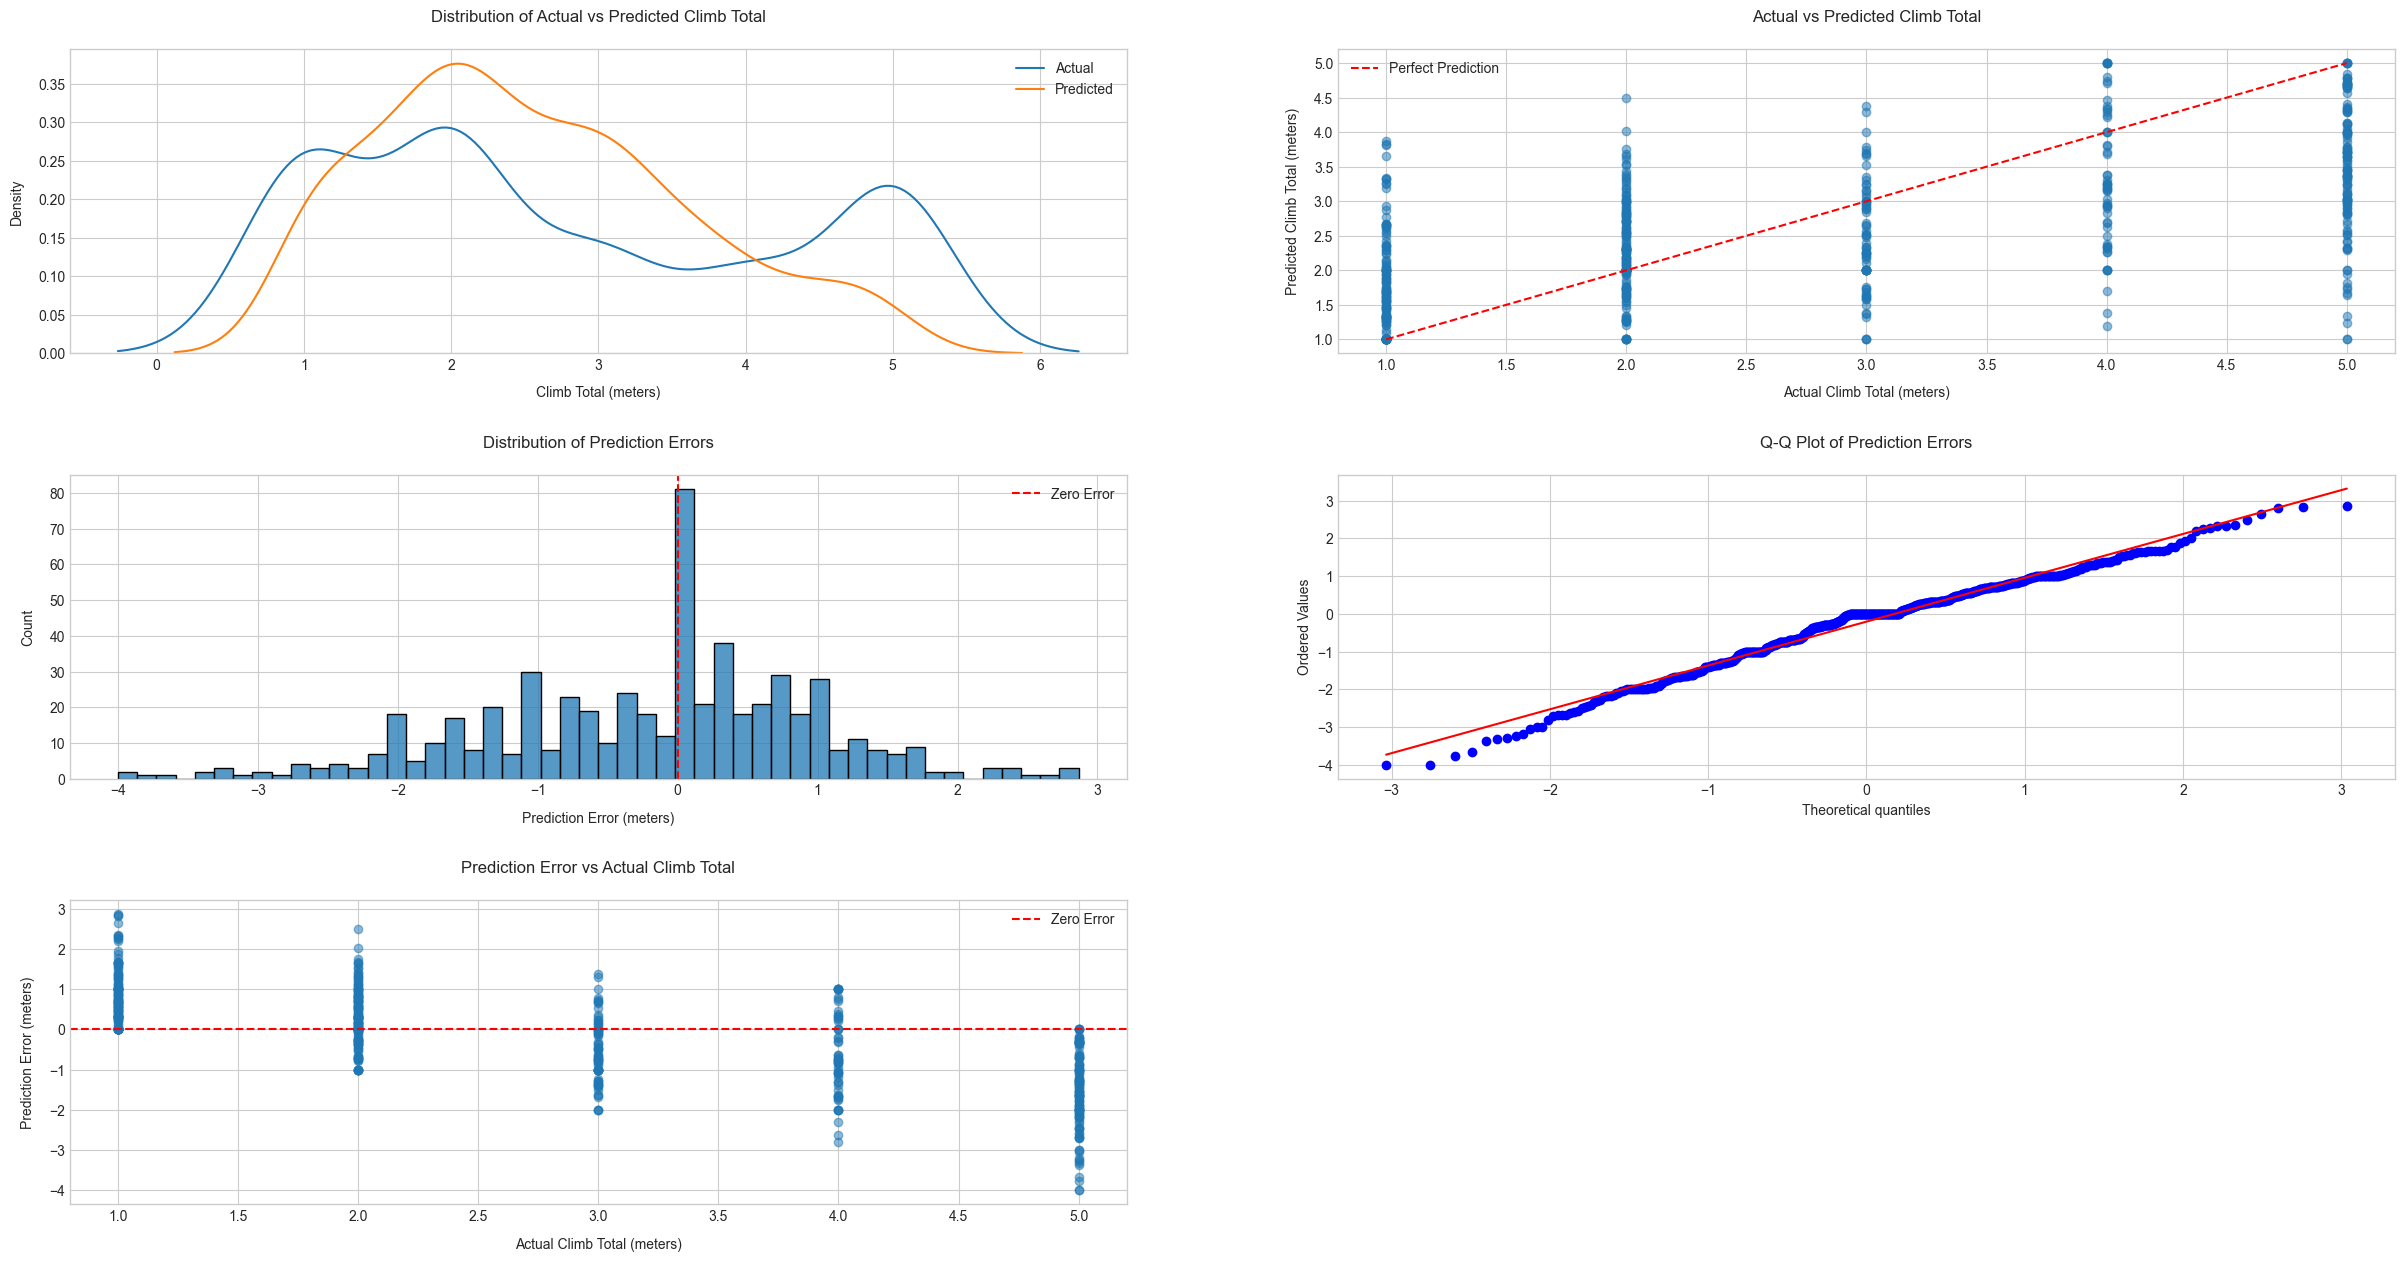

In [145]:


knnimp_alg_dr = races_agg_prof[races_agg_prof['profile'].notna()].copy()
random_indices = knnimp_alg_dr.sample(frac=0.2).index
y_test = knnimp_alg_dr.loc[random_indices, 'profile']
knnimp_alg_dr.loc[random_indices, 'profile'] = np.nan

metrics = predict_feature_knnimp(knnimp_alg_dr, n_neighbors=3, feature_to_predict='profile', type='categorical', y_true=y_test, features=pred_features_prof)

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")
del knnimp_alg_dr


Since the VotingRegressor has a better RMSE and R², we will use the predicted `profile` values for our dataframe.

In [ ]:
profile_pred_v1 = profile_pred.apply(lambda x: round(x, 0))

temp_obj_profile = races_v1.loc[races_v1['profile'].isna(), '_url'].map(profile_pred_v1)

# Update the 'profile' column
races_v1.loc[temp_obj_profile.index, 'profile'] = temp_obj_profile

races_v1['profile'].isna().sum()

## Now we will fill the `uci_points` missing values.


In [ ]:
races_points = races_prof.drop(columns=['points']).copy()
races_points['profile'] = races_v1['profile']

# Update the 'points' column with true values and predicted values for NaN entries
races_points['points'] = races_['points']



normal_features_points = normal_features_prof.copy()
del normal_features_points['points']
normal_features_points['profile'] = {'type': 'categorical', 'agg': 'first'}
FEATURES_POINTS = {**normal_features_points, **engineered_features}

pred_features_points = {name: {'type': props['type']} for name, props in FEATURES_POINTS.items()}

agg_dict_points = {name: props['agg'] for name, props in FEATURES_POINTS.items()}
agg_dict_points['date'] = 'first'
agg_dict_points['points'] = 'mean'

races_agg_points = races_points.groupby(["_url", "cyclist"]).agg(agg_dict_points)

races_agg_points.sample(frac=0.4).head(10)

del races_agg_prof
del races_prof

In [12]:
import gc
# del races_points

gc.collect()



16959

In [ ]:
results_points, summary_points, points_pred =  compare_algorithms(races_agg_points, "points", features=pred_features_points)

In [16]:

normal_features_points = normal_features.copy()
del normal_features_points['points']
normal_features_points['profile'] = {'type': 'categorical', 'agg': 'first'}
FEATURES_POINTS = {**normal_features_points, **engineered_features}

def recover_from_file_df(normal_features_to_normlize):
    df = pd.read_csv('races_filled.csv')
    engineering_features_t1(df)
    for feature, info in normal_features_to_normlize.items():
        preprocess_helper_scaler(df, {feature: {'type': info['type']}})

    
    
    return df

races_v1 = pd.read_csv('races_filled.csv')

for feature, info in normal_features_points.items():
    preprocess_helper_scaler(races_v1, {feature: {'type': info['type']}})


races_points = races_v1[list(normal_features_points.keys()) + ['_url', 'cyclist']].copy()
races_points['points'] = races_['points']
races_points['date'] = races_['date']

preprocess_helper_imputer(races_points, normal_features_points)

agg_dict_points = {name: props['agg'] for name, props in normal_features_points.items()}
agg_dict_points['date'] = 'first'
agg_dict_points['points'] = 'mean'


races_agg_points =races_points.groupby(["_url", "cyclist"]).agg(agg_dict_points)

races_points


length  startlist_quality  is_tarmac  profile  position  \
0      -0.073997           0.367430        1.0      0.0 -1.533334   
1      -0.073997           0.367430        1.0      0.0 -1.512675   
2      -0.073997           0.367430        1.0      0.0 -1.492015   
3      -0.073997           0.367430        1.0      0.0 -1.471356   
4      -0.073997           0.367430        1.0      0.0 -1.450697   
...          ...                ...        ...      ...       ...   
589860 -2.453712          -0.586361        1.0      0.0  2.433281   
589861 -2.453712          -0.586361        1.0      0.0  2.453941   
589862 -2.453712          -0.586361        1.0      0.0  2.474600   
589863 -2.453712          -0.586361        1.0      0.0  2.495260   
589864 -2.453712          -0.586361        1.0      0.0  2.515919   

        cyclist_age                         _url             cyclist  points  \
0         -1.682270  tour-de-france/1978/stage-6          sean-kelly   100.0   
1         -0.385465  tour-de-france/1978/stage-6    gerrie-knetemann   100.0   
2         -1.163548  tour-de-france/1978/stage-6      rene-bittinger   100.0   
3          0.392619  tour-de-france/1978/stage-6      joseph-bruyere   100.0   
4         -0.385465  tour-de-france/1978/stage-6    sven-ake-nilsson   100.0   
...             ...                          ...                 ...     ...   
589860    -0.904187   giro-d-italia/2010/stage-1       anders-lund-1    80.0   
589861    -0.126103   giro-d-italia/2010/stage-1  andrea-masciarelli    80.0   
589862    -1.163548   giro-d-italia/2010/stage-1         marco-corti    80.0   
589863     2.467508   giro-d-italia/2010/stage-1       robbie-mcewen    80.0   
589864    -0.385465   giro-d-italia/2010/stage-1     martin-pedersen    80.0   

                       date  
0       1978-07-05 04:02:24  
1       1978-07-05 04:02:24  
2       1978-07-05 04:02:24  
3       1978-07-05 04:02:24  
4       1978-07-05 04:02:24  
...                     ...  
589860  2010-05-08 00:11:38  
589861  2010-05-08 00:11:40  
589862  2010-05-08 00:11:41  
589863  2010-05-08 00:11:48  
589864  2010-05-08 00:11:49  

[589865 rows x 10 columns]

In [ ]:


den_alg_df = races_agg_points[races_agg_points['points'].notna()].copy()
den_alg_df = den_alg_df.groupby(list(normal_features_points.keys()) + ['points']).agg({'date': 'first'}).reset_index()

random_indices = den_alg_df.sample(frac=0.2).index
y_test = den_alg_df.loc[random_indices, 'points']
den_alg_df.loc[random_indices, 'points'] = np.nan

local_normal_features_points = normal_features_points.copy()

del local_normal_features_points['cyclist_age']
del local_normal_features_points['profile']

predictions_points, stats_races_points = predict_feature_density(
    den_alg_df, segmentation_features=local_normal_features_points, n_clusters_final=5, feature_to_predict='points', run_silhouette=False, plot_clusters=False
)

print_density_info(stats_races, predictions_points, y_test)

del den_alg_df

In [ ]:

knnimp_alg_dr = races_agg_points[races_agg_points['points'].notna()].copy()
random_indices = knnimp_alg_dr.sample(frac=0.2).index
y_test = knnimp_alg_dr.loc[random_indices, 'points']
knnimp_alg_dr.loc[random_indices, 'points'] = np.nan

metrics = predict_feature_knnimp(knnimp_alg_dr, n_neighbors=3, feature_to_predict='points', type='numeric', y_true=y_test, features=pred_features_points)

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")

del knnimp_alg_dr

In [109]:
import shutil
from pathlib import Path
from datetime import datetime

def move_to_tmp(file_path, keep_original=False):
    """
    Check if file exists and move it to /tmp folder.
    
    Args:
        file_path (str): Path to the file to be moved
        keep_original (bool): If True, copy file instead of moving it
    
    Returns:
        str: Path to the new location if successful, None if file doesn't exist
    """
    try:
        # Convert to Path object for easier handling
        file_path = Path(file_path)
        
        # Check if file exists
        if not file_path.exists():
            print(f"File {file_path} does not exist")
            return None
            
        # Create a new filename with timestamp to avoid conflicts
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        new_filename = f"{file_path.stem}_{timestamp}{file_path.suffix}"
        tmp_path = Path('/tmp') / new_filename
        
        # Move or copy the file
        if keep_original:
            shutil.copy2(file_path, tmp_path)
            print(f"File copied to {tmp_path}")
        else:
            shutil.move(file_path, tmp_path)
            print(f"File moved to {tmp_path}")
            
        return str(tmp_path)
        
    except PermissionError:
        print(f"Permission denied: Cannot access {file_path}")
        return None
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None


In [147]:
points_pred_v1 = points_pred.apply(lambda x: round(x, 0))

temp_obj_points = races_.loc[races_['points'].isna(), ['_url', 'cyclist']].apply(lambda x: points_pred_v1[x['_url'], x['cyclist']], axis=1)

races_v1.loc[temp_obj_points.index, 'points'] = temp_obj_points

races_v1['points'].isna().sum()



np.int64(0)

In [104]:


races_v1 = pd.read_csv('races_filled.csv')

warnings.filterwarnings('ignore')
normal_features_uci_points = normal_features.copy()
normal_features_uci_points['climb_total'] = {'type': 'numeric', 'agg': 'mean'}

for feature, info in normal_features_uci_points.items():
    preprocess_helper_scaler(races_v1, {feature: {'type': info['type']}})

extra = ['_url', 'cyclist', 'date', 'cyclist_team', 'delta']
races_uci_points = races_v1[list(normal_features_uci_points.keys()) + extra].copy()
engineering_features_t1(races_uci_points)

preprocess_helper_imputer(races_uci_points, normal_features_uci_points)

races_uci_points['uci_points'] = races_['uci_points']

FEATURES_UCI_POINTS = {**normal_features_uci_points, **engineered_features}



pred_features_uci_points = {name: {'type': props['type']} for name, props in FEATURES_UCI_POINTS.items()}

agg_dict_uci_points = {name: props['agg'] for name, props in FEATURES_UCI_POINTS.items()}
agg_dict_uci_points['date'] = 'first'
agg_dict_uci_points['uci_points'] = 'mean'



races_agg_uci_points = races_uci_points.groupby(["_url", "cyclist"]).agg(agg_dict_uci_points)

warnings.filterwarnings('default')
races_agg_uci_points.sample(frac=0.2).head(10)

length    points  \
_url                           cyclist                                         
tour-de-france/1987/stage-15   dario-montani             -0.043011  0.198030   
giro-d-italia/2002/stage-6     angel-vicioso              0.359805 -0.169522   
giro-d-italia/2023/stage-11    michael-matthews           0.809100 -0.169522   
tour-de-france/1990/stage-20   frederic-brun             -1.878924  0.198030   
tour-de-france/2000/stage-10   orlando-sergio-rodrigues   0.592199  0.198030   
tour-de-france/2003/stage-6    stuart-o-grady             0.979522  0.198030   
tour-de-france/1986/stage-12   jan-van-wijk               0.785861  0.198030   
tour-de-france/1988/stage-7    guido-bontempi             0.902058  0.198030   
giro-d-italia/2003/stage-12    jose-joaquin-castelblanco  0.282340 -0.169522   
volta-a-catalunya/2018/stage-2 jorge-cubero               0.136707 -0.720849   

                                                          startlist_quality  \
_url                           cyclist                                        
tour-de-france/1987/stage-15   dario-montani                       1.867745   
giro-d-italia/2002/stage-6     angel-vicioso                      -0.476005   
giro-d-italia/2023/stage-11    michael-matthews                   -0.699345   
tour-de-france/1990/stage-20   frederic-brun                       2.253991   
tour-de-france/2000/stage-10   orlando-sergio-rodrigues            0.882424   
tour-de-france/2003/stage-6    stuart-o-grady                      1.541932   
tour-de-france/1986/stage-12   jan-van-wijk                        2.025397   
tour-de-france/1988/stage-7    guido-bontempi                      2.206696   
giro-d-italia/2003/stage-12    jose-joaquin-castelblanco          -0.964724   
volta-a-catalunya/2018/stage-2 jorge-cubero                       -1.161789   

                                                          is_tarmac  profile  \
_url                           cyclist                                         
tour-de-france/1987/stage-15   dario-montani                    1.0      1.0   
giro-d-italia/2002/stage-6     angel-vicioso                    1.0      1.0   
giro-d-italia/2023/stage-11    michael-matthews                 1.0      1.0   
tour-de-france/1990/stage-20   frederic-brun                    1.0      0.0   
tour-de-france/2000/stage-10   orlando-sergio-rodrigues         1.0      4.0   
tour-de-france/2003/stage-6    stuart-o-grady                   1.0      1.0   
tour-de-france/1986/stage-12   jan-van-wijk                     1.0      3.0   
tour-de-france/1988/stage-7    guido-bontempi                   1.0      0.0   
giro-d-italia/2003/stage-12    jose-joaquin-castelblanco        1.0      4.0   
volta-a-catalunya/2018/stage-2 jorge-cubero                     1.0      1.0   

                                                          position  \
_url                           cyclist                               
tour-de-france/1987/stage-15   dario-montani              0.801184   
giro-d-italia/2002/stage-6     angel-vicioso             -1.450697   
giro-d-italia/2023/stage-11    michael-matthews          -0.934210   
tour-de-france/1990/stage-20   frederic-brun             -0.252448   
tour-de-france/2000/stage-10   orlando-sergio-rodrigues   0.470633   
tour-de-france/2003/stage-6    stuart-o-grady            -1.140805   
tour-de-france/1986/stage-12   jan-van-wijk               0.181401   
tour-de-france/1988/stage-7    guido-bontempi            -0.768934   
giro-d-italia/2003/stage-12    jose-joaquin-castelblanco -0.397064   
volta-a-catalunya/2018/stage-2 jorge-cubero               0.863163   

                                                          cyclist_age  \
_url                           cyclist                                  
tour-de-france/1987/stage-15   dario-montani                -0.644826   
giro-d-italia/2002/stage-6     angel-vicioso                -0.904187   
giro-d-italia/2023/stage-11    michael-matthews         


Training Random Forest...
Random Forest Results:
RMSE: 3.36 meters
R²: 0.987
CV RMSE: 64.69 ± 8.16 meters

Training Gradient Boosting...
Gradient Boosting Results:
RMSE: 4.01 meters
R²: 0.974
CV RMSE: 67.81 ± 9.26 meters

Training XGBoost...
XGBoost Results:
RMSE: 3.47 meters
R²: 0.985
CV RMSE: 70.42 ± 9.23 meters

Training Huber...
Huber Results:
RMSE: 7.10 meters
R²: 0.742
CV RMSE: 96.47 ± 34.77 meters

Training Linear Regression...
Linear Regression Results:
RMSE: 6.83 meters
R²: 0.780
CV RMSE: 56.70 ± 9.01 meters

Training Ridge...
Ridge Results:
RMSE: 6.83 meters
R²: 0.780
CV RMSE: 56.70 ± 9.01 meters

Training Lasso...
Lasso Results:
RMSE: 6.91 meters
R²: 0.770
CV RMSE: 56.36 ± 10.83 meters

Training KNeighborsRegressor...
KNeighborsRegressor Results:
RMSE: 5.37 meters
R²: 0.916
CV RMSE: 69.61 ± 12.53 meters

Training HistGradientBoostingRegressor...
HistGradientBoostingRegressor Results:
RMSE: 3.02 meters
R²: 0.992
CV RMSE: 66.48 ± 12.31 meters

Training VotingRegressor...
Voti

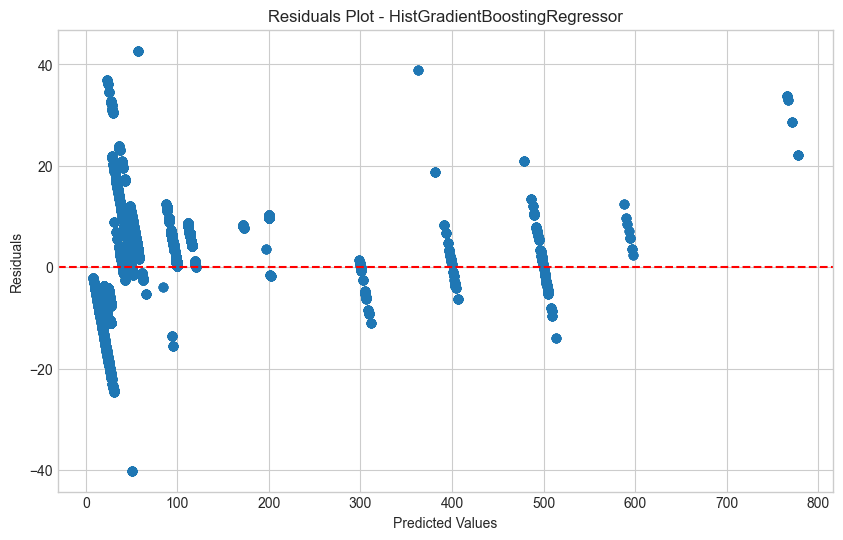


Summary of all models:
                                   RMSE        R²    CV RMSE  CV RMSE Std
HistGradientBoostingRegressor  3.021015  0.991567  66.476605    12.314766
Random Forest                  3.363538  0.987041  64.686367     8.160966
VotingRegressor                3.390184  0.986625  65.647605     9.650980
XGBoost                        3.465532  0.985396  70.419573     9.226738
Gradient Boosting              4.007297  0.973891  67.810781     9.257177
KNeighborsRegressor            5.371738  0.915697  69.608513    12.530860
Ridge                          6.828451  0.779872  56.697909     9.010670
Linear Regression              6.828501  0.779866  56.702939     9.012191
Lasso                          6.907466  0.769505  56.359894    10.834935
Huber                          7.103363  0.742224  96.472446    34.772270
Visualizations for the best model:


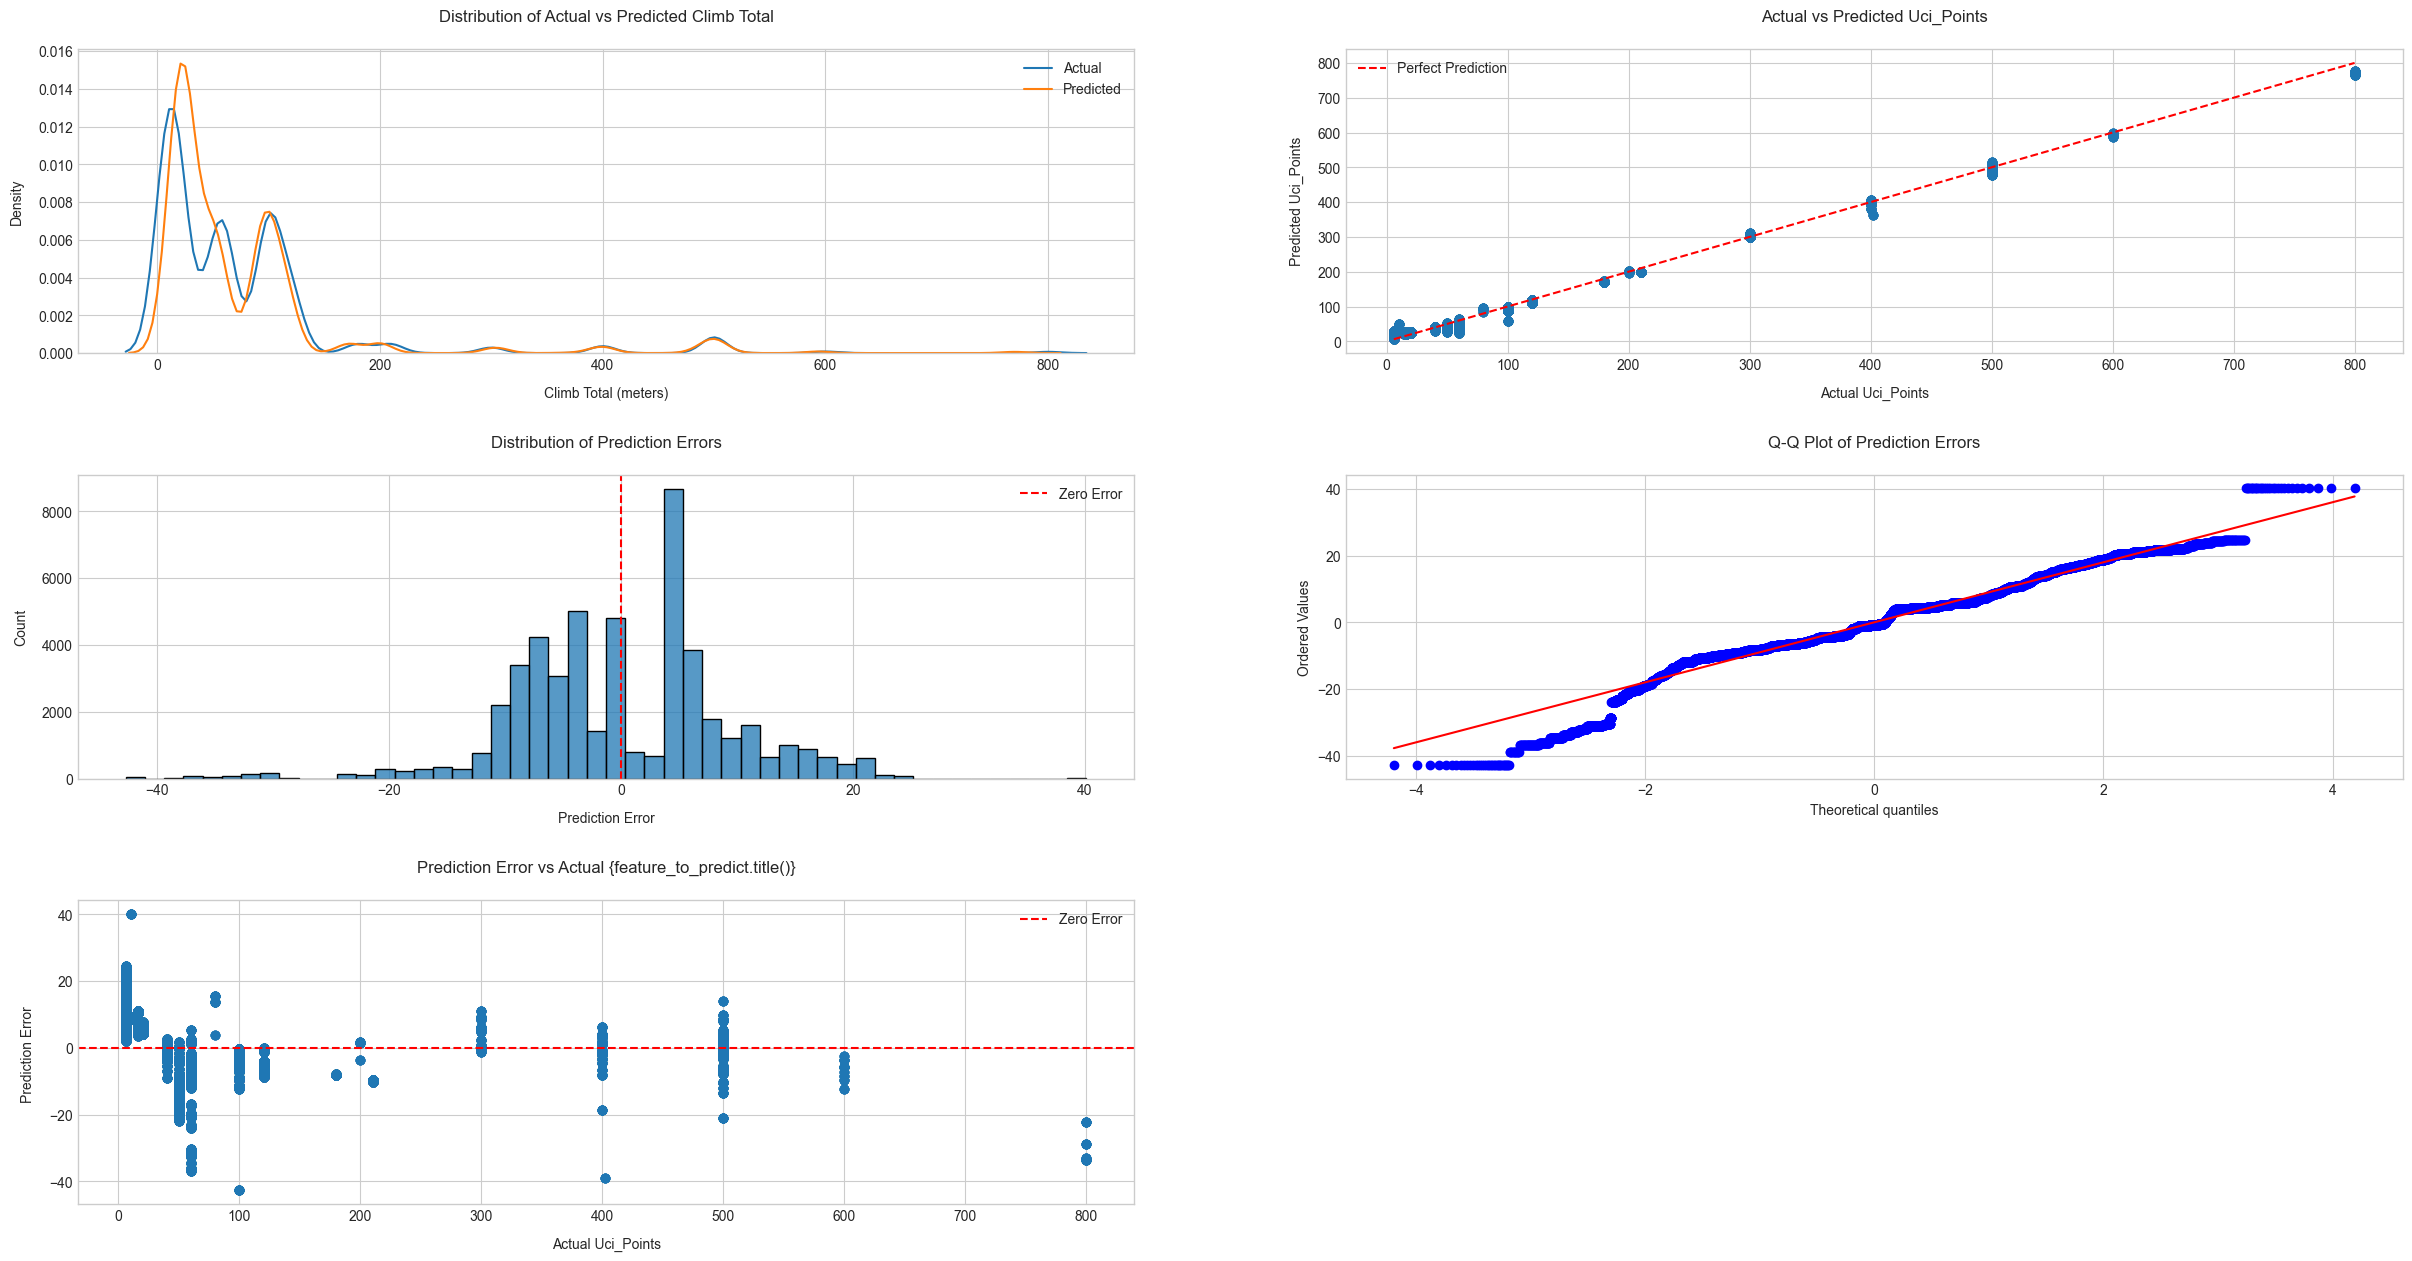

In [107]:

results_uci_points, summary_uci_points, uci_points_pred =  compare_algorithms(races_agg_uci_points, "uci_points", features=pred_features_uci_points)

In [ ]:


den_alg_df = races_agg_uci_points[races_agg_uci_points['uci_points'].notna()].copy()
random_indices = den_alg_df.sample(frac=0.2).index
y_test = den_alg_df.loc[random_indices, 'uci_points']move_to_tmp



predictions_uci_points.loc[random_indices, 'uci_points'] = y_test
create_prediction_visualizations(predictions_uci_points, y_test, stats_races_uci_points, feature_name="uci_points")
create_segment_analysis(predictions_uci_points, feature_name='uci_points')

In [ ]:


knnimp_alg_dr = races_agg_uci_points[races_agg_uci_points['uci_points'].notna()].copy()
random_indices = knnimp_alg_dr.sample(frac=0.2).index
y_test = knnimp_alg_dr.loc[random_indices, 'uci_points']
knnimp_alg_dr.loc[random_indices, 'uci_points'] = np.nan

metrics = predict_feature_knnimp(knnimp_alg_dr, n_neighbors=3, feature_to_predict='uci_points', type='numeric', y_true=y_test, features=pred_features_uci_points)

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")

del knnimp_alg_dr

In [110]:
# points_pred_v1 = points_pred.apply(lambda x: round(x, 0))

# temp_obj_points = races_.loc[races_['points'].isna(), ['_url', 'cyclist']].apply(lambda x: points_pred_v1[x['_url'], x['cyclist']], axis=1)

# races_v1.loc[temp_obj_points.index, 'points'] = temp_obj_points

# races_v1['points'].isna().sum()

uci_points_pred_v1 = uci_points_pred.apply(lambda x: round(x, 0))

temp_obj_uci = races_.loc[races_['uci_points'].isna(), ['_url', 'cyclist']].apply(lambda x: uci_points_pred_v1[x['_url'], x['cyclist']], axis=1)

races_v1 = pd.read_csv("races_filled.csv")

races_v1.loc[temp_obj_uci.index, 'uci_points'] = temp_obj_uci

nans = races_v1['uci_points'].isna().sum()
print(f"Number of missing values in uci_points column: {nans}")

if not nans:
    move_to_tmp('races_filled.csv')
    races_v1.to_csv("races_filled.csv", index=False)

races_v1.head(10) 


Number of missing values in uci_points column: 0
File moved to /tmp/races_filled_20241027_190635.csv


_url            name  points  uci_points    length  \
0  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
1  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
2  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
3  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
4  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
5  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
6  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
7  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
8  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   
9  tour-de-france/1978/stage-6  Tour de France   100.0       119.0  162000.0   

   climb_total  profile  startlist_quality  average_temperature  \
0       1101.0      1.0               1241                  NaN   
1       1101.0      1.0               1241                  NaN   
2       1101.0      1.0               1241                  NaN   
3       1101.0      1.0               1241                  NaN   
4       1101.0      1.0               1241                  NaN   
5       1101.0      1.0               1241                  NaN   
6       1101.0      1.0               1241                  NaN   
7       1101.0      1.0               1241                  NaN   
8       1101.0      1.0               1241                  NaN   
9       1101.0      1.0               1241                  NaN   

                  date  position            cyclist  cyclist_age  is_tarmac  \
0  1978-07-05 04:02:24         0         sean-kelly         22.0       True   
1  1978-07-05 04:02:24         1   gerrie-knetemann         27.0       True   
2  1978-07-05 04:02:24         2     rene-bittinger         24.0       True   
3  1978-07-05 04:02:24         3     joseph-bruyere         30.0       True   
4  1978-07-05 04:02:24         4   sven-ake-nilsson         27.0       True   
5  1978-07-05 04:02:51         5  jacques-esclassan         30.0       True   
6  1978-07-05 04:02:51         6  walter-planckaert         30.0       True   
7  1978-07-05 04:02:51         7        guy-sibille         30.0       True   
8  1978-07-05 04:02:51         8     jacques-bossis         26.0       True   
9  1978-07-05 04:02:51         9   bernard-bourreau         27.0       True   

   is_cobbled  is_gravel                          cyclist_team  delta  
0       False      False  vini-ricordi-pinarello-sidermec-1986    0.0  
1       False      False                           norway-1987    0.0  
2       False      False                                   NaN    0.0  
3       False      False              navigare-blue-storm-1993    0.0  
4       False      False                            spain-1991    0.0  
5       False      False               kelme-costa-blanca-2000   27.0  
6       False      False              navigare-blue-storm-1993   27.0  
7       False      False                                   NaN   27.0  
8       False      False                                   NaN   27.0  
9       False      False                                   NaN   27.0

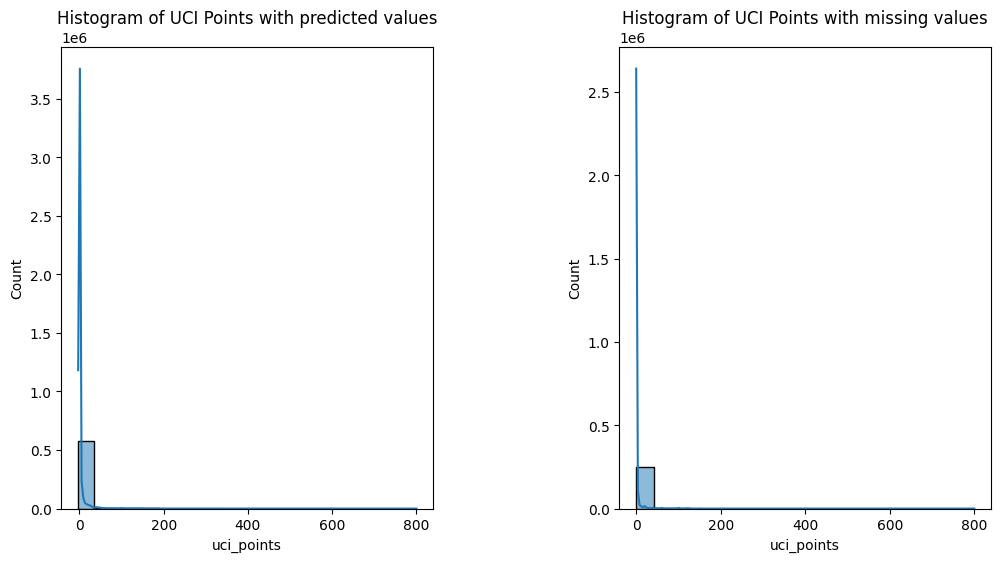

In [ ]:
# temp = races_.groupby(['position', 'delta']).agg(delta_counts=('delta', 'count')).reset_index()


# print(temp[temp['delta'] == 0.0][['position', 'delta_counts']])
races_filled = pd.read_csv('dataset/races_filled.csv')

fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
# Plot the histogram of `uci_points` column
sns.histplot(races_filled['uci_points'], bins='auto', kde=True, ax=ax1)
ax1.set_title('Histogram of UCI Points with predicted values')

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(races_['uci_points'], bins='auto', kde=True, ax=ax2)
ax2.set_title('Histogram of UCI Points with missing values')

plt.show()
plt.close()

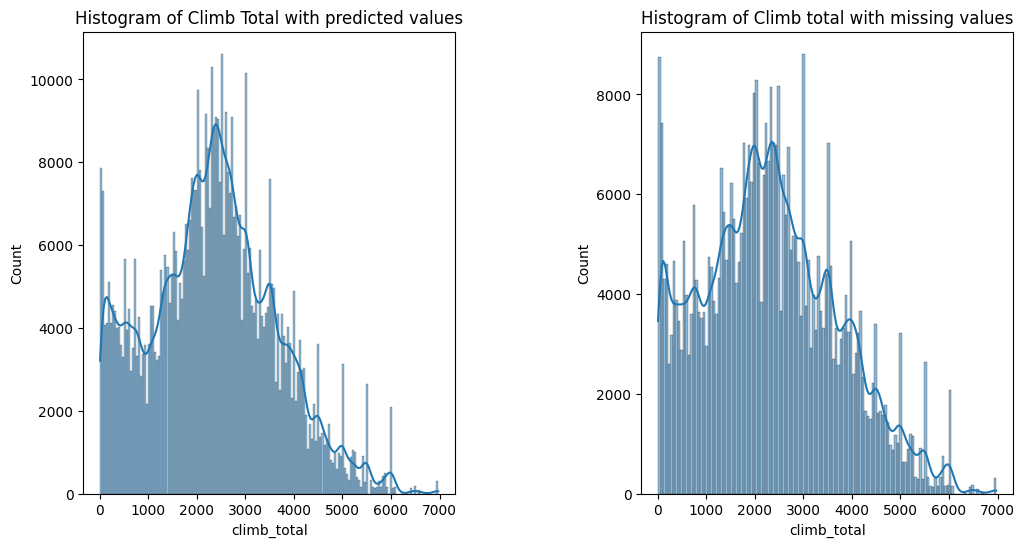

In [ ]:

fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
# Plot the histogram of `uci_points` column
sns.histplot(races_filled['climb_total'], bins='auto', kde=True, ax=ax1)
ax1.set_title('Histogram of Climb Total with predicted values')

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(races_['climb_total'], bins='auto', kde=True, ax=ax2)
ax2.set_title('Histogram of Climb total with missing values')

plt.show()
plt.close()

In [ ]:


fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
# Plot the histogram of `points` column
sns.histplot(races_filled['points'], bins='auto', kde=True, ax=ax1)
ax1.set_title('Histogram of Points with predicted values')

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(races_['points'], bins='auto', kde=True, ax=ax2)
ax2.set_title('Histogram of Points with missing values')

plt.show()
plt.close()

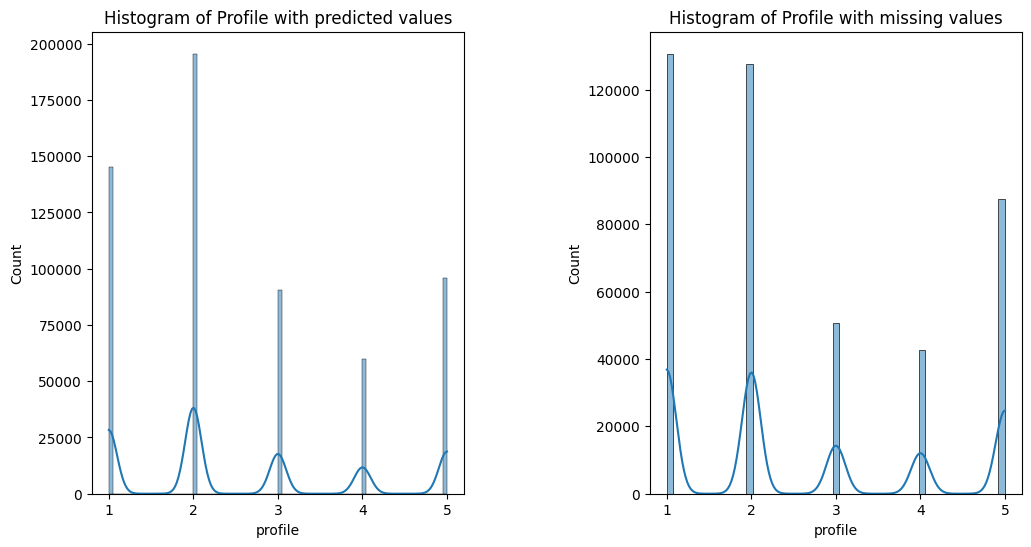

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
# Plot the histogram of `uci_points` column
sns.histplot(races_filled['profile'], bins='auto', kde=True, ax=ax1)
ax1.set_title('Histogram of Profile with predicted values')

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(races_['profile'], bins='auto', kde=True, ax=ax2)
ax2.set_title('Histogram of Profile with missing values')

plt.show()
plt.close()